# Credit scoring

In this competition we're provided with:
- train and test datasets of 73,799 and 36,349 samples respectivly and 18 features except target one;
- model that we're not allowed to change;
- baseline that gives **ROC_AUC = 0.672**

More details on the features:
- client_id - client ID
- education - level of education
- sex - gender of the borrower
- age - the age of the borrower
- car - car availability flag
- car_type - flag of a foreign car
- decline_app_cnt - the number of rejected past applications
- good_work - flag for having a “good” job
- bki_request_cnt - number of requests in BKI
- home_address - home address categorizer
- work_address - work address categorizer
- income - the borrower's income
- foreign_passport - availability of a foreign passport
- sna - connection of the borrower with the bank's clients
- first_time - the limitation of the availability of information about the borrower
- score_bki - score based on data from the BKI
- region_rating - region rating
- app_date - date of application submission
- default - the default flag on the loan

Target variable **default** is binary.

We had gaps in education and its correlations with car_type, foreign_passport, good_work, income. The problem was solved by makeing dubble t-test to compare income in Empties with the other education categories by each of the binary features.

Data investigation (first look):
- the bank has more not defaulted clients (87% vs 13%) - **sampling is unbalanced**
- gaps in education in both train & test datasets
- number of uniques and tops in both train & test datasets are the same
- we have 4 binary features, 1 categorical and 1 - date
- the test dataset is representative of the training dataset
- all client_id are unique

Data investigation (after EDA) - the most interesting points:
1. We have more applications from people with scholar education and them have the most cases of default.
2. The same situation with home and work address categories as wel as with car, foreign car and passport, good work flags.
3. Gender doesn't impact on defaults.
4. Age has very small impact on defaults, only people over 70 have the lowest number of default cases (but there're the smallest number of applications from people of this age)

Our first model on raw data:
- roc_auc = 0.584
- f1_score = 0.0
- doesn't recognise any default cases

What has been done here to improve the results:
- logarithm needed features (roc_auc = 0.739, f1_score = 0.0367)
- normalise with logarithm needed features (normalization didn't improve the results)
    - StandardScaler (roc_auc = 0.738, f1_score = 0.0396)
- getting rid of strongly correlated variables didn't improve the results
- work with outliers didn't improve the results
- work with categorical features -> dummy (roc_auc = 0.742, f1_score = 0.0427)
- work with dates (**roc_auc = 0.745, f1_score = 0.0437**)

***We still have very pure f1_score. It isn't the key metric but in my opinion is very important in this case.***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import warnings
warnings.simplefilter('ignore')

from pandas import Series

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')  # beautiful graphs
plt.rcParams['figure.figsize'] = (12, 4)  # figure size

import seaborn as sns
%matplotlib inline

import random
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
df_train.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [5]:
df_test.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

In [6]:
sample_submission.head()

client_id   default
0      66799  0.441004
1      25379  0.138092
2      28825  0.373370
3      37530  0.476501
4       4264  0.304640

# DATA
## Structure investigation

In [7]:
print('Train dataset shape:', df_train.shape)
print('Test dataset shape:', df_test.shape)
print('Submission shape:', sample_submission.shape, end='\n\n')
print(f'Test dataset is {round(df_test.shape[0]/(df_test.shape[0]+df_train.shape[0])*100, 2)}% of the whole dataset')
print(f'Submission is {round(sample_submission.shape[0]/df_test.shape[0]*100, 2)}% of test dataset', end='\n\n')
print('Differences in train and test datasets columns:', list(set(df_train.columns) - set(df_test.columns)), end='\n\n')

print('Train dataset:', end='\n\n')
display(pd.value_counts(df_train.dtypes))
print('\n\nTest dataset:', end='\n\n')
display(pd.value_counts(df_test.dtypes))

Train dataset shape: (73799, 19)
Test dataset shape: (36349, 18)
Submission shape: (24354, 2)

Test dataset is 33.0% of the whole dataset
Submission is 67.0% of test dataset

Differences in train and test datasets columns: ['default']

Train dataset:



int64      12
object      6
float64     1
dtype: int64



Test dataset:



int64      11
object      6
float64     1
dtype: int64

In [8]:
df_train.default.unique()

array([0, 1])

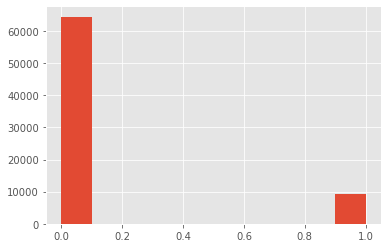

In [9]:
# look at which customers the bank has more: defaulted (1) or not (0)
df_train.default.hist()

In [10]:
df_train.default.value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

1. Target variable **default** is binary.
2. Bank has more not defaulted clients (87% vs 13%) - sampling is unbalanced

In [11]:
df_train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

### Structure of non-numerical features

In [12]:
print('Train dataset')
display(df_train.select_dtypes(exclude='number').sample(5))
print('Test dataset')
display(df_test.select_dtypes(exclude='number').sample(5))

Train dataset


app_date education sex car car_type foreign_passport
42718  17FEB2014       GRD   M   Y        Y                Y
70752  24APR2014       UGR   F   Y        N                N
48428  23APR2014       PGR   M   Y        N                N
8384   26MAR2014       SCH   F   N        N                N
68177  09APR2014       GRD   F   Y        N                N

Test dataset


app_date education sex car car_type foreign_passport
34549  01APR2014       SCH   F   N        N                N
17820  22JAN2014       SCH   M   N        N                N
25935  03APR2014       GRD   F   N        N                N
4144   30MAR2014       UGR   M   Y        Y                Y
15801  26JAN2014       GRD   F   N        N                N

In [13]:
print('Train dataset')
display(df_train.describe(exclude='number'))
print('Test dataset')
display(df_test.describe(exclude='number'))

Train dataset


app_date education    sex    car car_type foreign_passport
count       73799     73492  73799  73799    73799            73799
unique        120         5      2      2        2                2
top     18MAR2014       SCH      F      N        N                N
freq         1018     38860  41562  49832    59791            62733

Test dataset


app_date education    sex    car car_type foreign_passport
count       36349     36178  36349  36349    36349            36349
unique        120         5      2      2        2                2
top     18MAR2014       SCH      F      N        N                N
freq          473     19138  20274  24458    29349            30988

- gaps in **education** in both train & test datasets
- number of uniques and tops in both train & test datasets are the same
- we have 4 binary features, 1 categorical and 1 - date

In [14]:
# fill up gaps in education with Empty for now
df_train.education = df_train.education.fillna('Empty')
df_test.education = df_test.education.fillna('Empty')

education



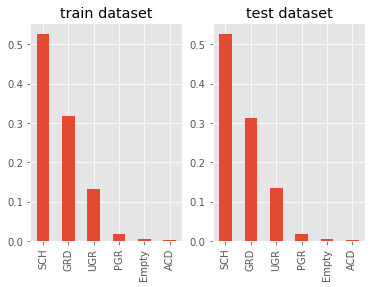

sex



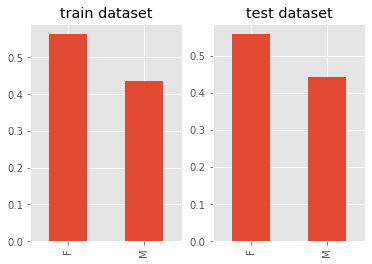

car



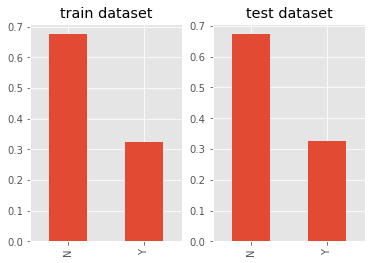

car_type



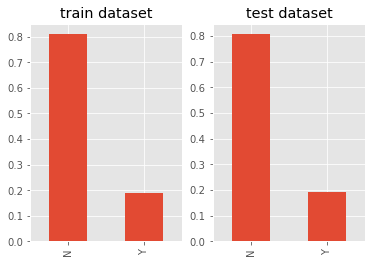

foreign_passport



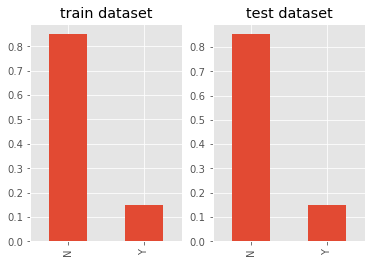

In [15]:
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    print(col, end='\n\n')
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    
    # Plotting bars for the first subplot (train dataset)
    train_counts = df_train[col].value_counts(normalize=True)
    train_counts.plot.bar(ax=axes[0], title=col)

    # Plotting bars for the second subplot (test dataset)
    test_counts = df_test[col].value_counts(normalize=True)
    test_counts.plot.bar(ax=axes[1], title=col)
    
    axes[0].set(title = 'train dataset')
    axes[1].set(title = 'test dataset')
    
    plt.show()

In [16]:
df_train.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', 'Empty'], dtype=object)

- 'SCH' - scholar, 
- 'GRD' - graduated, 
- 'UGR' - undergraduated, 
- 'PGR' - postgraduated, 
- 'ACD'- academic, 
- 'Empty' - gaps

### Structure of numerical features

In [17]:
print('Train dataset')
display(df_train.select_dtypes(include='number').sample(5))
print('Test dataset')
display(df_test.select_dtypes(include='number').sample(5))

Train dataset


client_id  age  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
28608      16299   41                1          0  -1.824227                4   
19532      80893   64                1          0  -1.435953                3   
7634       76857   35                6          0  -1.477686                0   
25293      27969   29                0          1  -2.945873                3   
66205      43255   29                0          0  -2.440749                0   

       region_rating  home_address  work_address  income  sna  first_time  \
28608             40             2             3   33000    1           1   
19532             60             2             3   30000    1           4   
7634              80             2             3   40000    2           3   
25293             60             2             3   35000    4           4   
66205             80             2             3   80000    1           4   

       default  
28608        1  
19532        0  
7634         0  
25293        0  
66205        0

Test dataset


client_id  age  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
7580       18121   33                0          0  -2.462567                1   
3072       76013   35                0          0  -2.353052                3   
36260      88537   31                0          0  -1.850109                3   
6209       47910   30                1          0  -1.135782                1   
20054      12659   43                0          0  -1.425121                5   

       region_rating  home_address  work_address  income  sna  first_time  
7580              50             1             2   30000    4           1  
3072              50             1             1   25000    1           3  
36260             40             2             3   20000    1           3  
6209              50             1             1   60000    1           3  
20054             50             2             3   40000    4           3

In [18]:
print('Train dataset')
display(df_train.describe(include='number'))
print('Test dataset')
display(df_test.describe(include='number'))

Train dataset


client_id           age  decline_app_cnt     good_work  \
count   73799.000000  73799.000000     73799.000000  73799.000000   
mean    55137.965094     39.280641         0.275749      0.164894   
std     31841.921168     11.520378         0.804272      0.371087   
min         1.000000     21.000000         0.000000      0.000000   
25%     27440.500000     30.000000         0.000000      0.000000   
50%     55274.000000     37.000000         0.000000      0.000000   
75%     82758.500000     48.000000         0.000000      0.000000   
max    110147.000000     72.000000        33.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  73799.000000     73799.000000   73799.000000  73799.000000   
mean      -1.904724         2.000339      56.725701      1.575509   
std        0.498231         2.252073      13.055717      0.527631   
min       -3.624586         0.000000      20.000000      1.000000   
25%       -2.259534         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.569831         3.000000      60.000000      2.000000   
max        0.199773        53.000000      80.000000      3.000000   

       work_address          income           sna    first_time       default  
count  73799.000000    73799.000000  73799.000000  73799.000000  73799.000000  
mean       2.496280    41099.775417      1.733330      2.765458      0.126994  
std        0.689818    46166.322400      1.123622      1.009463      0.332968  
min        1.000000     1000.000000      1.000000      1.000000      0.000000  
25%        2.000000    20000.000000      1.000000      2.000000      0.000000  
50%        3.000000    30000.000000      1.000000      3.000000      0.000000  
75%        3.000000    48000.000000      2.000000      4.000000      0.000000  
max        3.000000  1000000.000000      4.000000      4.000000      1.000000

Test dataset


client_id           age  decline_app_cnt     good_work  \
count   36349.000000  36349.000000     36349.000000  36349.000000   
mean    54945.647473     39.186002         0.268040      0.166772   
std     31706.052195     11.513258         0.788478      0.372777   
min         4.000000     21.000000         0.000000      0.000000   
25%     27744.000000     30.000000         0.000000      0.000000   
50%     54657.000000     37.000000         0.000000      0.000000   
75%     82322.000000     48.000000         0.000000      0.000000   
max    110148.000000     71.000000        30.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  36349.000000     36349.000000   36349.000000  36349.000000   
mean      -1.904152         2.014471      56.802938      1.573798   
std        0.501764         2.296789      13.086646      0.527428   
min       -3.574197         0.000000      20.000000      1.000000   
25%       -2.261909         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.563957         3.000000      60.000000      2.000000   
max        0.188820        47.000000      80.000000      3.000000   

       work_address          income           sna    first_time  
count  36349.000000    36349.000000  36349.000000  36349.000000  
mean       2.501087    40835.755729      1.728053      2.765798  
std        0.683227    43802.180951      1.120686      1.011560  
min        1.000000     1000.000000      1.000000      1.000000  
25%        2.000000    20000.000000      1.000000      2.000000  
50%        3.000000    30000.000000      1.000000      3.000000  
75%        3.000000    48000.000000      2.000000      4.000000  
max        3.000000  1000000.000000      4.000000      4.000000

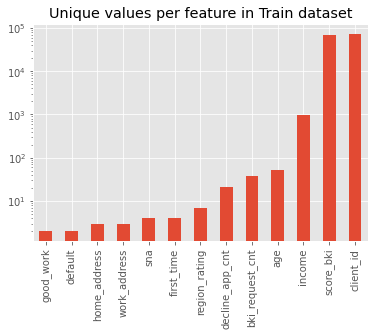

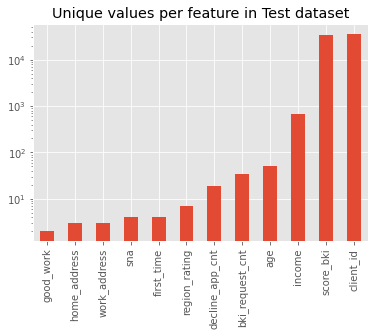

In [19]:
# For each numerical feature compute number of unique entries
unique_values = df_train.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale !!!!!!!!!!!
unique_values.plot.bar(logy=True, 
                       #figsize=(12, 4), 
                       title="Unique values per feature in Train dataset")
plt.show()

# For each numerical feature compute number of unique entries
unique_values = df_test.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale !!!!!!!!!!!
unique_values.plot.bar(logy=True, 
                       #figsize=(12, 4), 
                       title="Unique values per feature in Test dataset")
plt.show()

In [20]:
print('Train dataset client_id count:', df_train.client_id.count())
print('Train dataset unique client_id count:', df_train.client_id.nunique(), end='\n\n')

print('Test dataset client_id count:', df_test.client_id.count())
print('Test dataset unique client_id count:', df_test.client_id.nunique(), end='\n\n')

Train dataset client_id count: 73799
Train dataset unique client_id count: 73799

Test dataset client_id count: 36349
Test dataset unique client_id count: 36349



In [21]:
len(list((set(df_train.client_id.unique()) & set(df_test.client_id.unique()))))

0

- the test dataset is representative of the training dataset
- all client_id are unique

In [22]:
# all client_id are unique
df_train.drop('client_id', axis=1, inplace=True)
df_test.drop('client_id', axis=1, inplace=True)

In [23]:
for col in list(df_train.columns):
    print(col, df_train[col].nunique())

app_date 120
education 6
sex 2
age 52
car 2
car_type 2
decline_app_cnt 21
good_work 2
score_bki 69096
bki_request_cnt 38
region_rating 7
home_address 3
work_address 3
income 966
sna 4
first_time 4
foreign_passport 2
default 2


In [24]:
binary_features = ['sex', 'car', 'car_type', 'foreign_passport'] # good_work, default (target)

In [25]:
for col in binary_features:
    print(col)
    #display(df_train[col].value_counts(normalize=True))
    display(df_test[col].value_counts(normalize=True))

sex


F    0.557759
M    0.442241
Name: sex, dtype: float64

car


N    0.672866
Y    0.327134
Name: car, dtype: float64

car_type


N    0.807422
Y    0.192578
Name: car_type, dtype: float64

foreign_passport


N    0.852513
Y    0.147487
Name: foreign_passport, dtype: float64

In [26]:
label_encoder = LabelEncoder()
labels_dict = {}

for col in binary_features:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_test[col] = label_encoder.transform(df_test[col])
    labels_dict.setdefault(str(col), dict(enumerate(label_encoder.classes_)))
    
    #print(col, dict(enumerate(label_encoder.classes_)))
labels_dict

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'foreign_passport': {0: 'N', 1: 'Y'}}

In [27]:
for col in binary_features:
    print(col)
    #display(df_train[col].value_counts(normalize=True))
    display(df_test[col].value_counts(normalize=True))

sex


0    0.557759
1    0.442241
Name: sex, dtype: float64

car


0    0.672866
1    0.327134
Name: car, dtype: float64

car_type


0    0.807422
1    0.192578
Name: car_type, dtype: float64

foreign_passport


0    0.852513
1    0.147487
Name: foreign_passport, dtype: float64

In [28]:
binary_features = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work'] # default (target)
categorical_features = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
date_features = ['app_date']
numeric_features = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

## Quality investigation
### Duplicates

In [29]:
# Check number of duplicates while ignoring the index feature
print(f"You seem to have {df_train.duplicated().sum()} duplicates in your Train dataset.")
print(f"You seem to have {df_test.duplicated().sum()} duplicates in your Test dataset.")

You seem to have 0 duplicates in your Train dataset.
You seem to have 0 duplicates in your Test dataset.


### Missing values

In [30]:
count=0
for i in df_train.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values in Train dataset: {}, that is {}% of all rows'.format(count, round(count/df_train.shape[0]*100, 2)))

count=0
for i in df_test.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values in Test dataset: {}, that is {}% of all rows'.format(count, round(count/df_test.shape[0]*100, 2)))

Total number of rows with missing values in Train dataset: 0, that is 0.0% of all rows
Total number of rows with missing values in Test dataset: 0, that is 0.0% of all rows


### Unwanted entries and recording errors

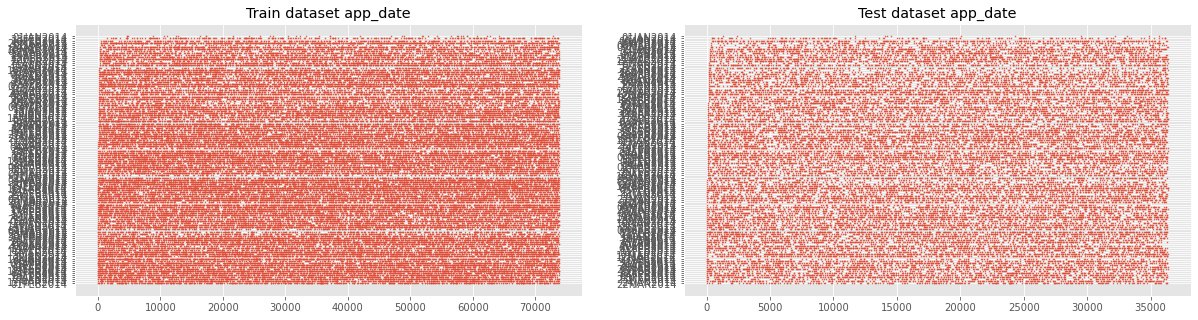

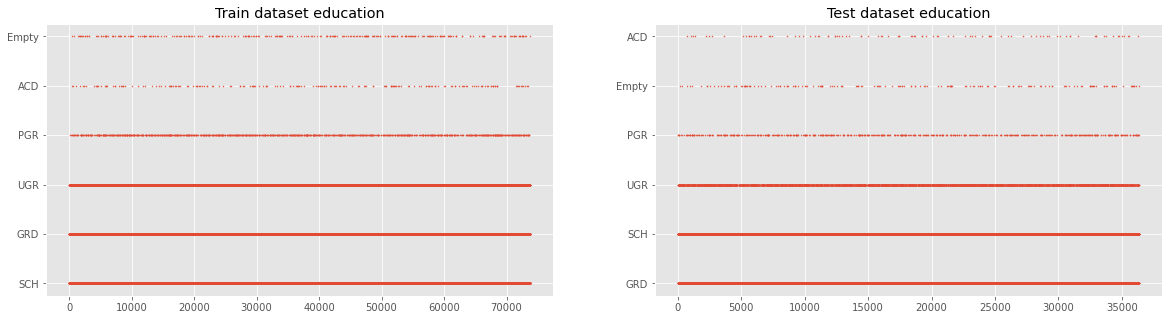

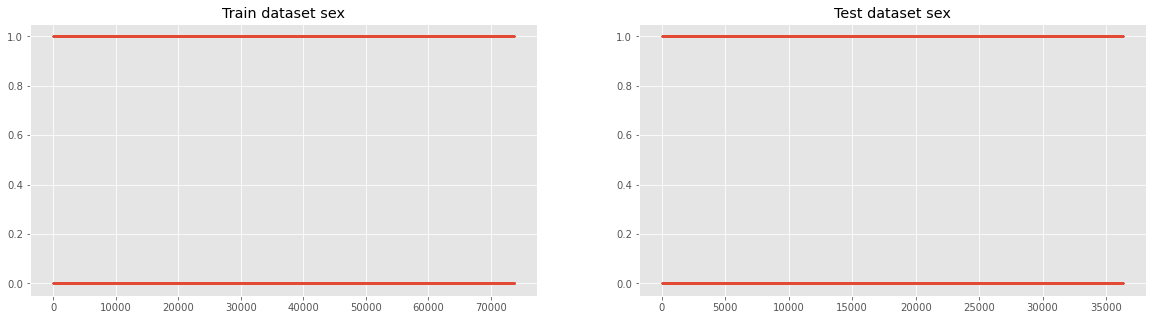

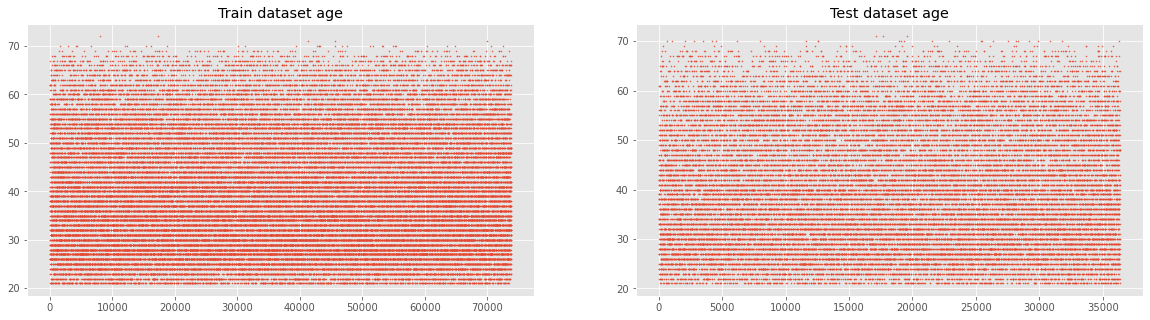

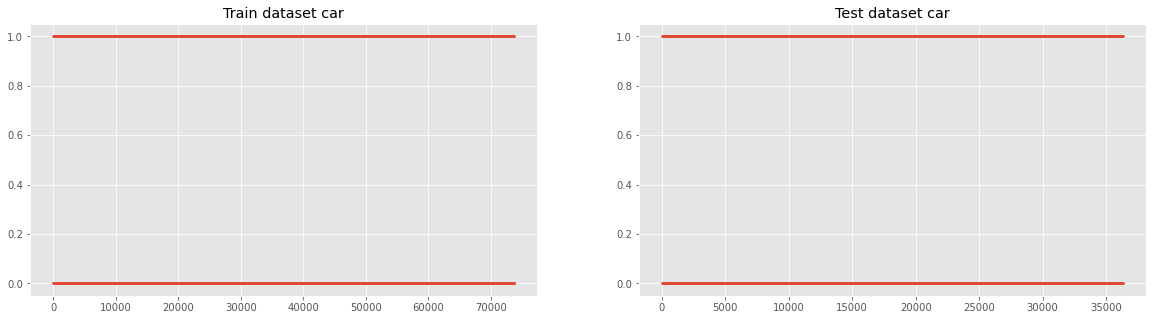

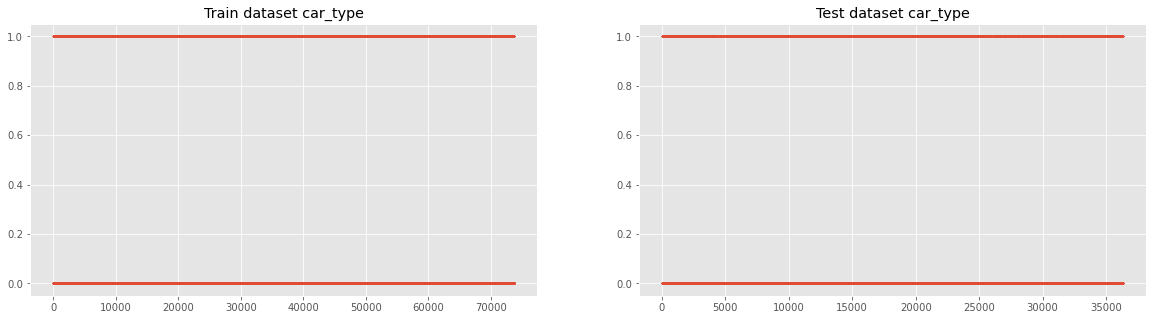

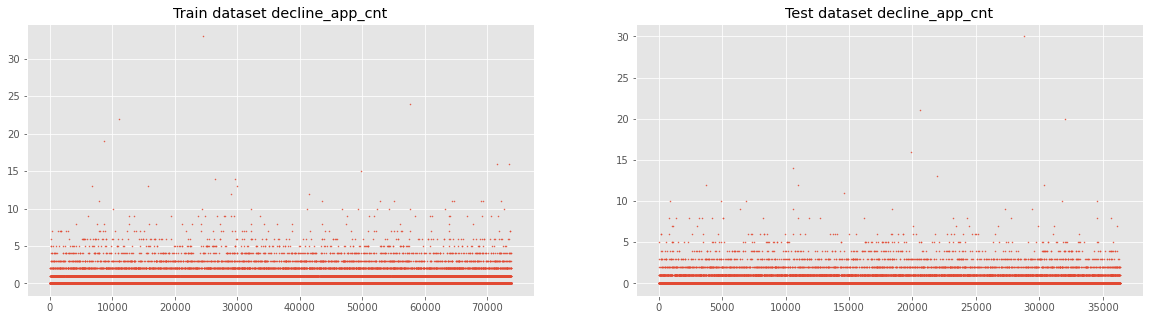

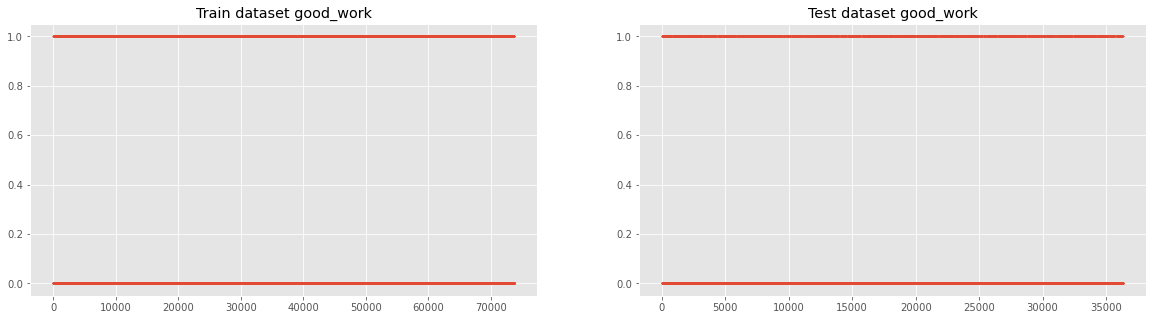

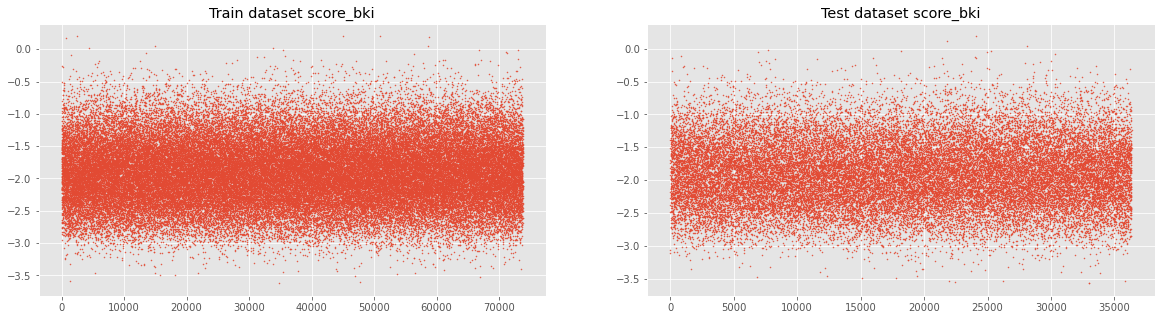

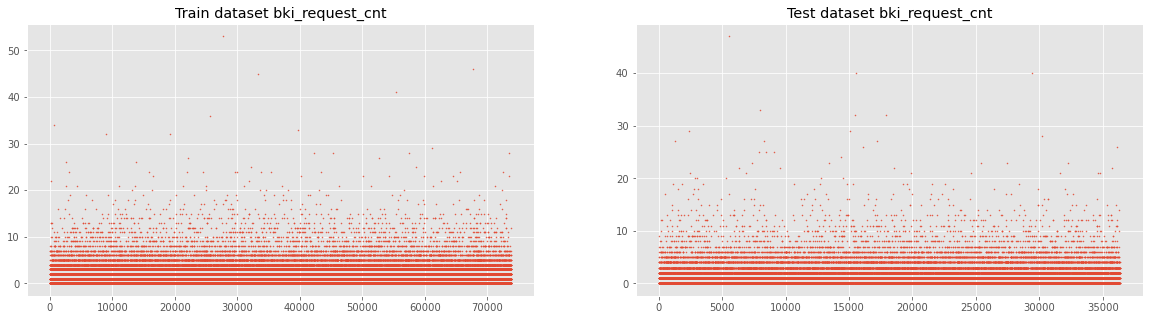

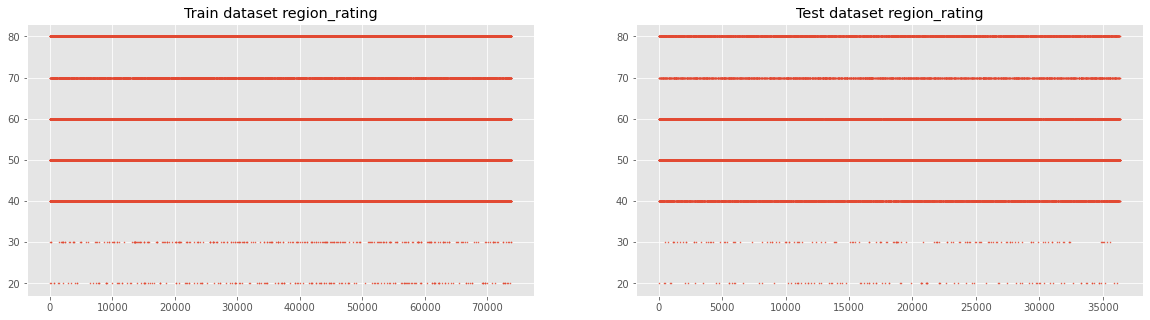

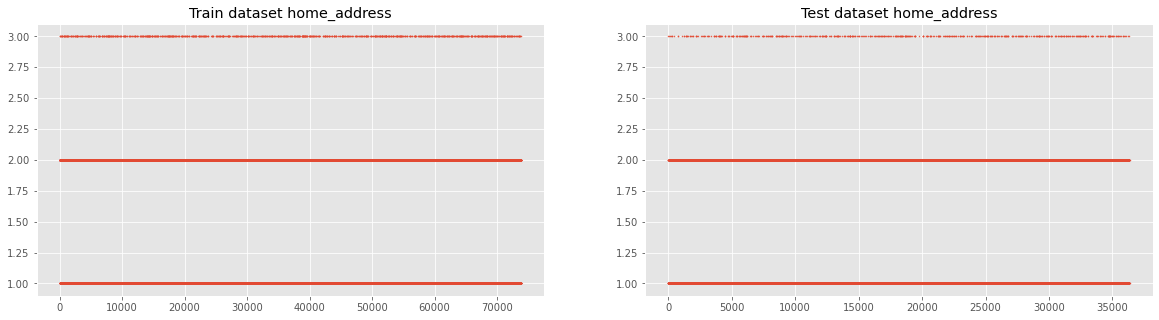

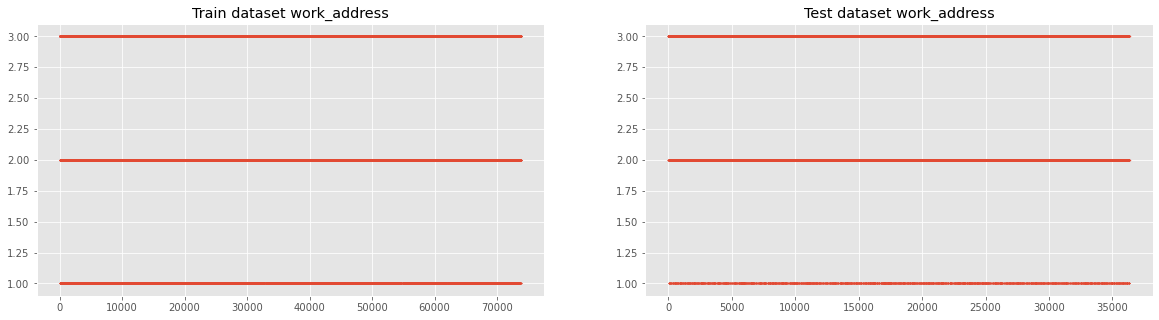

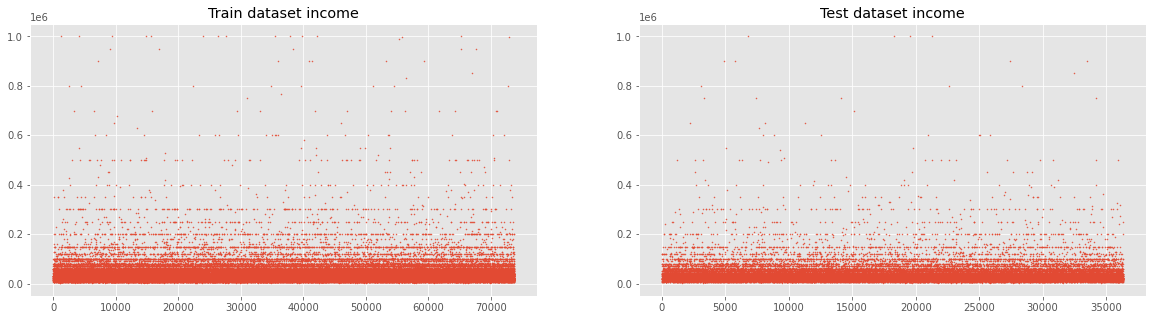

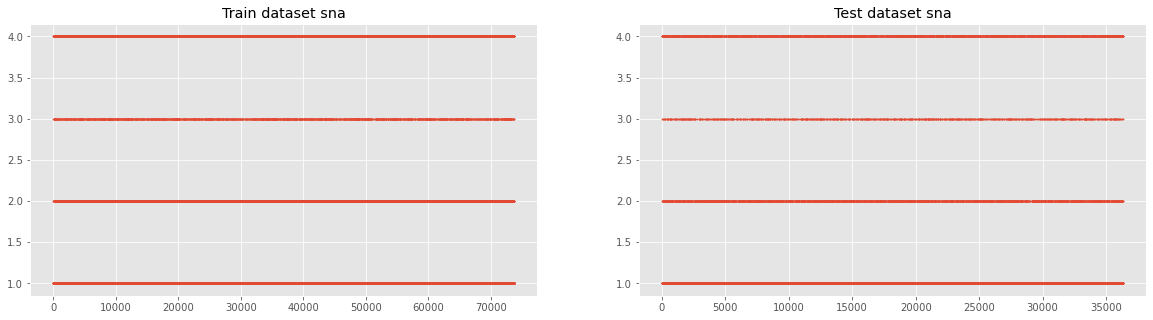

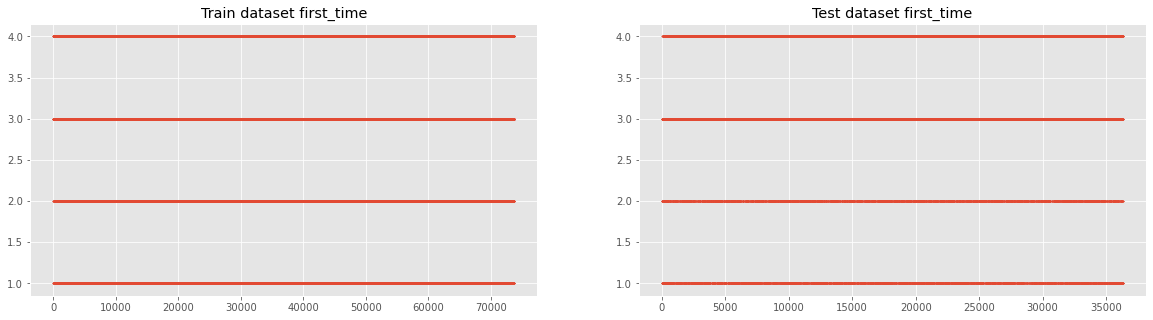

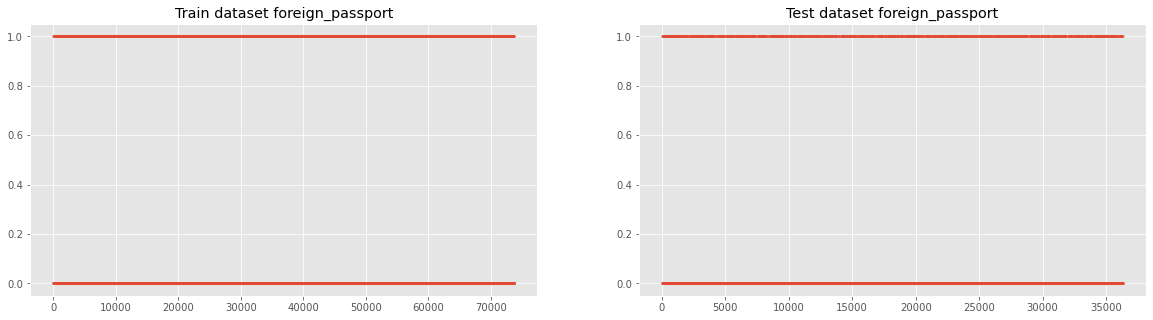

In [31]:
for col in list(df_train.columns):
    if col != 'default':
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

        axes[0].plot(df_train[col],
                     lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
                     marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
                     markersize=1
                    )
    
        axes[1].plot(df_test[col],
                     lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
                     marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
                     markersize=1
                    )
    
        axes[0].set(title = ' '.join(['Train dataset', str(col)]))
        axes[1].set(title = ' '.join(['Test dataset', str(col)]))
        plt.show()


Outliers are possible in columns:
- decline_app_cnt
- score_bki
- bki_request_cnt
- income

decline_app_cnt in train total count 73799
decline_app_cnt in train interquartile outliers count 12585
decline_app_cnt in train interquartile outliers % 17.05
decline_app_cnt in train z_score outliers count 1720
decline_app_cnt in train z_score outliers % 2.33

decline_app_cnt in test total count 36349
decline_app_cnt in test interquartile outliers count 6092
decline_app_cnt in test interquartile outliers % 16.76
decline_app_cnt in test z_score outliers count 835
decline_app_cnt in test z_score outliers % 2.3



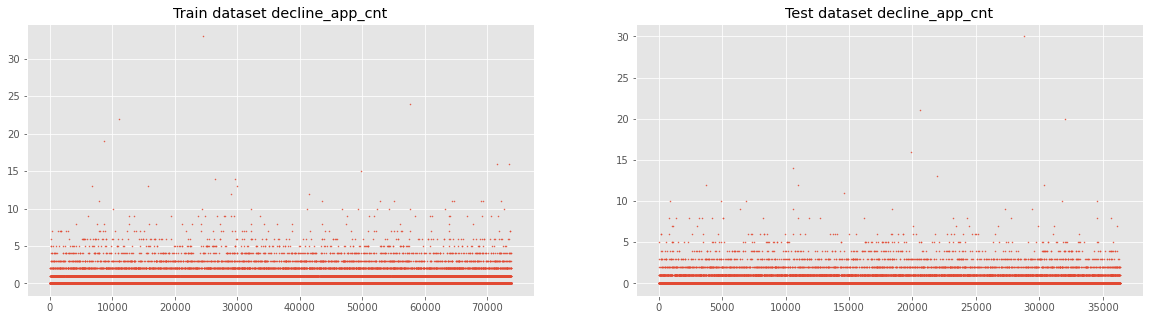

score_bki in train total count 73799
score_bki in train interquartile outliers count 351
score_bki in train interquartile outliers % 0.48
score_bki in train z_score outliers count 164
score_bki in train z_score outliers % 0.22

score_bki in test total count 36349
score_bki in test interquartile outliers count 184
score_bki in test interquartile outliers % 0.51
score_bki in test z_score outliers count 86
score_bki in test z_score outliers % 0.24



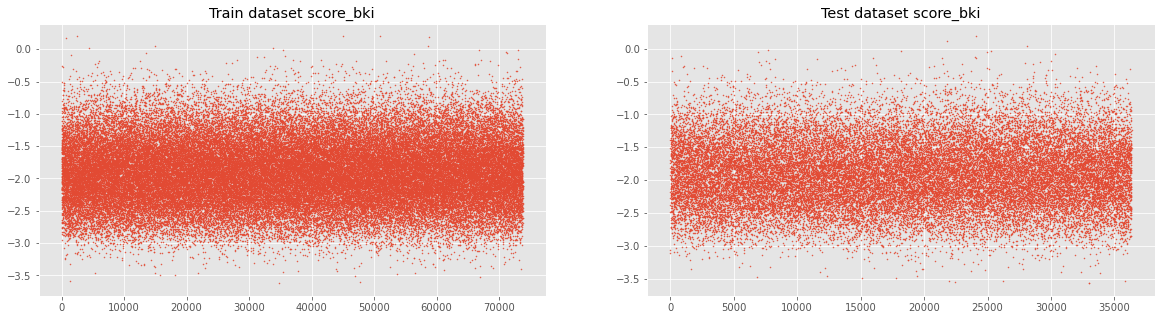

bki_request_cnt in train total count 73799
bki_request_cnt in train interquartile outliers count 1755
bki_request_cnt in train interquartile outliers % 2.38
bki_request_cnt in train z_score outliers count 1247
bki_request_cnt in train z_score outliers % 1.69

bki_request_cnt in test total count 36349
bki_request_cnt in test interquartile outliers count 881
bki_request_cnt in test interquartile outliers % 2.42
bki_request_cnt in test z_score outliers count 654
bki_request_cnt in test z_score outliers % 1.8



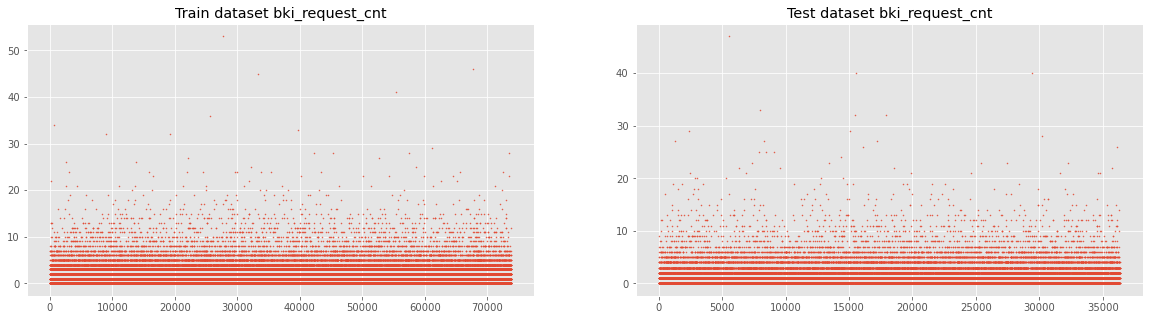

income in train total count 73799
income in train interquartile outliers count 4695
income in train interquartile outliers % 6.36
income in train z_score outliers count 1172
income in train z_score outliers % 1.59

income in test total count 36349
income in test interquartile outliers count 2305
income in test interquartile outliers % 6.34
income in test z_score outliers count 562
income in test z_score outliers % 1.55



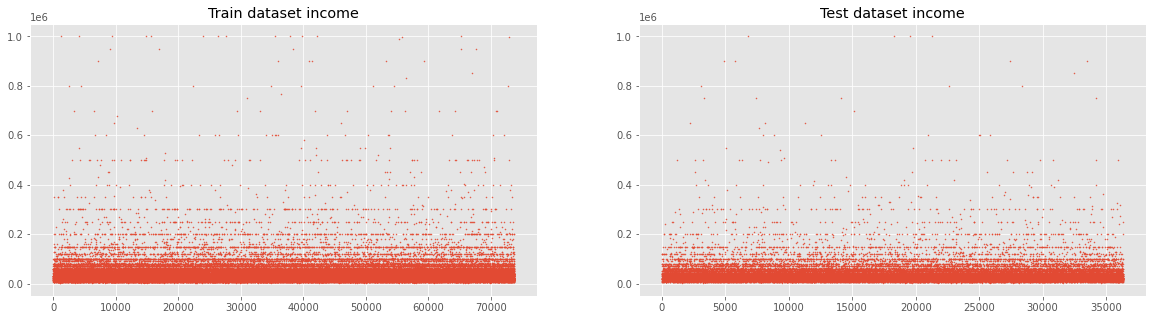

In [32]:
for col in ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']:
    
    print(col, 'in train total count', df_train[col].count())
    
    quartile_1, quartile_3 = np.percentile(df_train[col], [25, 75])
    iqr = quartile_3 - quartile_1
    otl_i = np.where((df_train[col] > quartile_3 + (iqr * 1.5)) | (df_train[col] < quartile_1 - (iqr * 1.5)))[0]
    
    mean_y = np.mean(df_train[col])
    std_y = np.std(df_train[col])
    z_scores = [(y - mean_y) / std_y for y in df_train[col]]
    otl_z = np.where(np.abs(z_scores) > 3)[0]
    
    print(col, 'in train interquartile outliers count', len(otl_i))
    print(col, 'in train interquartile outliers %', round(len(otl_i)/df_train[col].count()*100, 2))
    print(col, 'in train z_score outliers count', len(otl_z))
    print(col, 'in train z_score outliers %', round(len(otl_z)/df_train[col].count()*100, 2), end='\n\n')
    
    otl_i = np.where((df_test[col] > quartile_3 + (iqr * 1.5)) | (df_test[col] < quartile_1 - (iqr * 1.5)))[0]
    z_scores = [(y - mean_y) / std_y for y in df_test[col]]
    otl_z = np.where(np.abs(z_scores) > 3)[0]
    
    print(col, 'in test total count', df_test[col].count())
    print(col, 'in test interquartile outliers count', len(otl_i))
    print(col, 'in test interquartile outliers %', round(len(otl_i)/df_test[col].count()*100, 2))
    print(col, 'in test z_score outliers count', len(otl_z))
    print(col, 'in test z_score outliers %', round(len(otl_z)/df_test[col].count()*100, 2), end='\n\n')
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].plot(df_train[col],
                     lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
                     marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
                     markersize=1
                    )
    
    axes[1].plot(df_test[col],
                     lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
                     marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
                     markersize=1
                    )
    
    axes[0].set(title = ' '.join(['Train dataset', str(col)]))
    axes[1].set(title = ' '.join(['Test dataset', str(col)]))
    plt.show()

Outliers in columns:
- decline_app_cnt - 2% of samples
- score_bki - 0.2% of samples lie
- bki_request_cnt - 2% of samples
- income - 1.5% of samples

Look at the relationship with target...

## Content investigation
### Feature distribution

In [33]:
col_list = categorical_features.copy()
col_list.extend(binary_features)

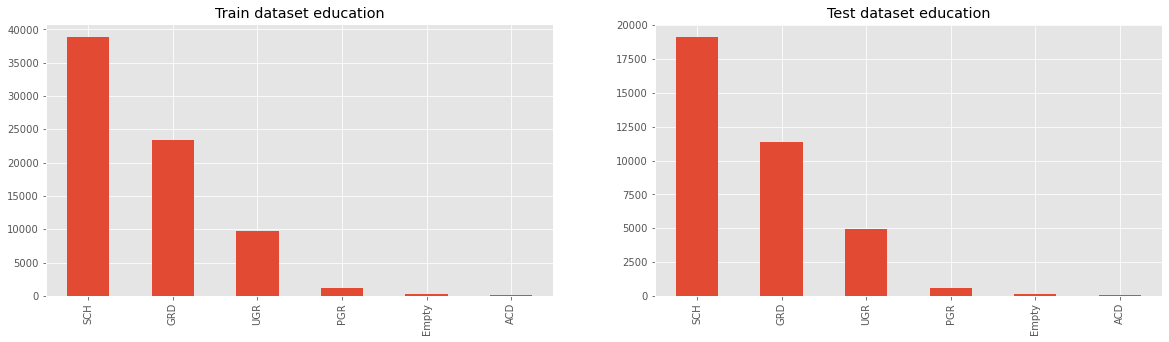

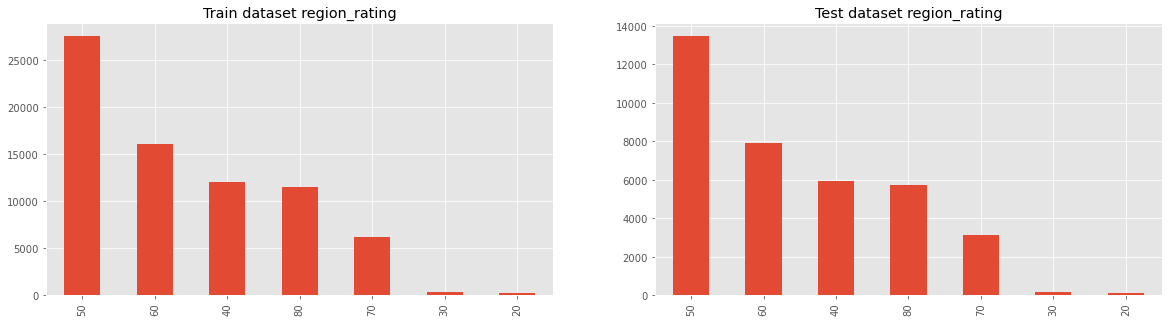

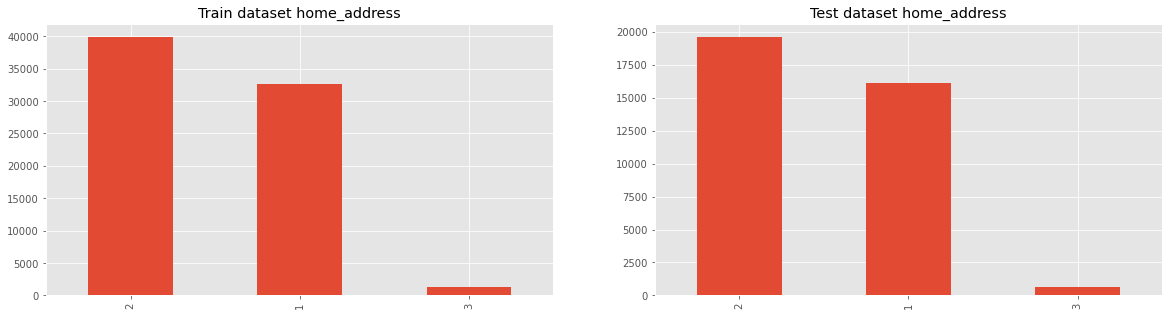

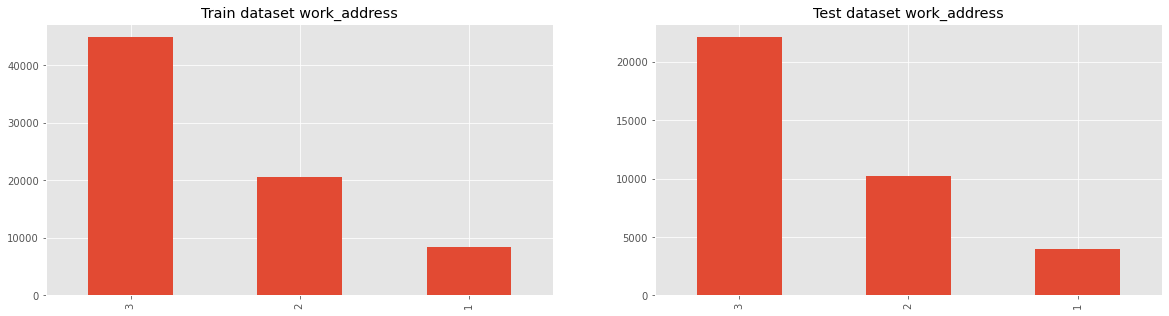

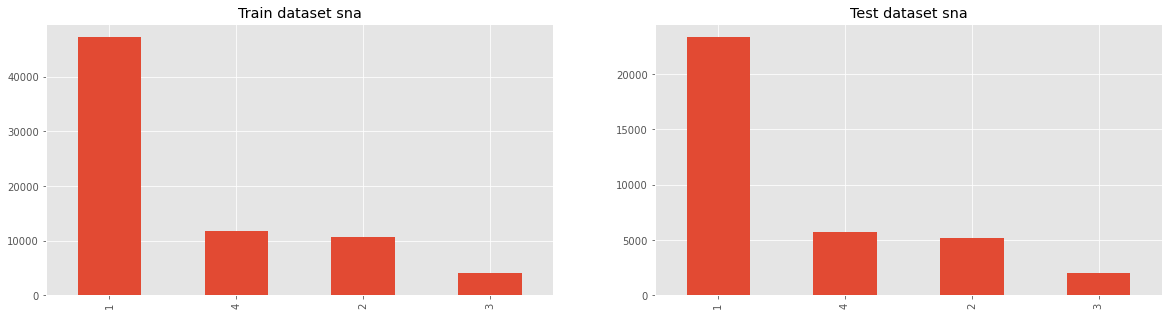

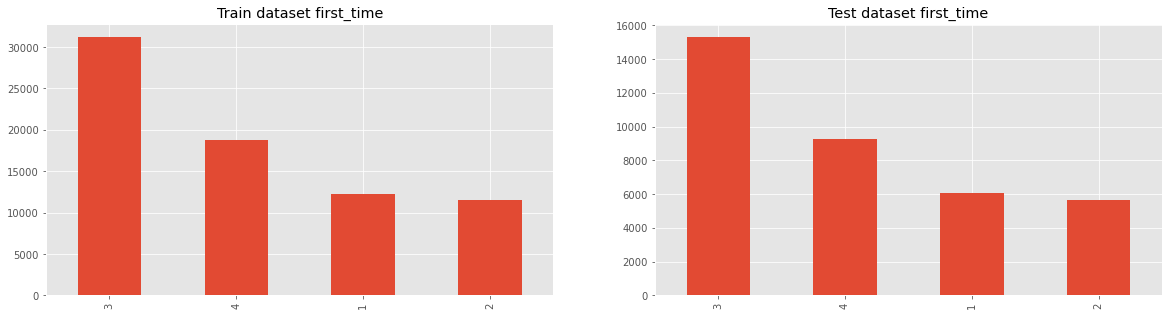

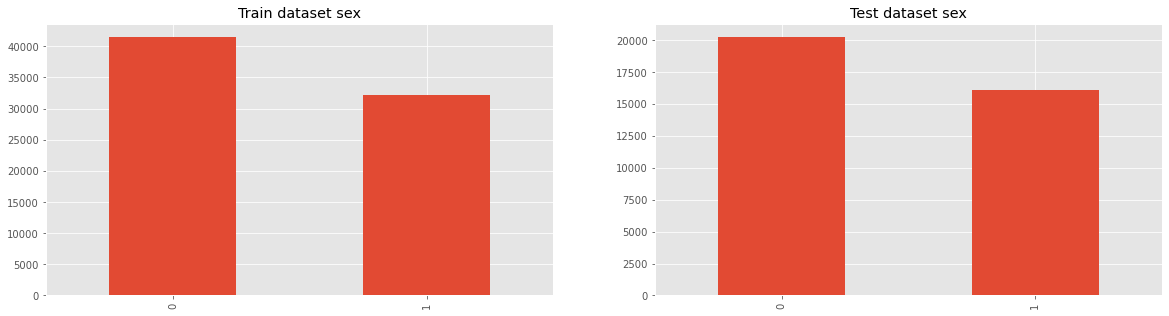

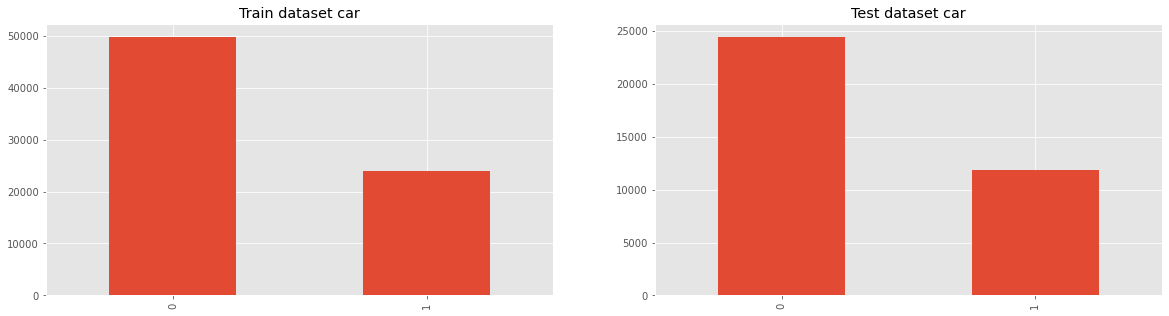

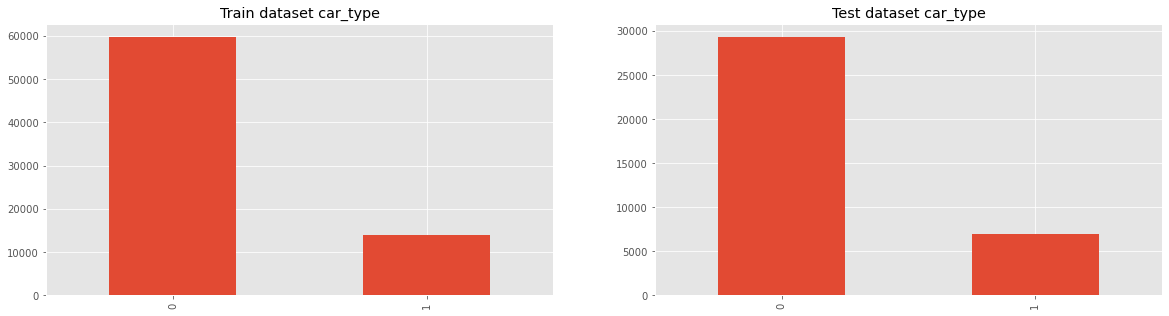

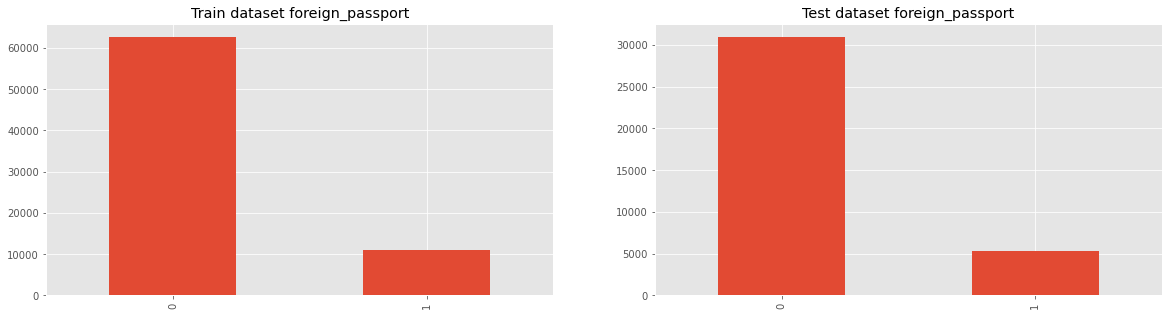

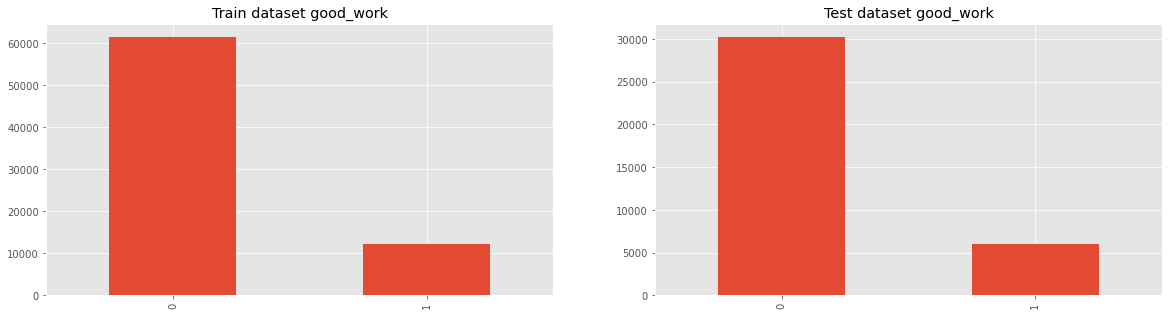

In [34]:
for col in col_list:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))
    
    # Plotting bars for the first subplot (train dataset)
    train_counts = df_train[col].value_counts()
    train_counts.plot.bar(ax=axes[0], title=col)

    # Plotting bars for the second subplot (test dataset)
    test_counts = df_test[col].value_counts()
    test_counts.plot.bar(ax=axes[1], title=col)
    
    axes[0].set(title = ' '.join(['Train dataset', str(col)]))
    axes[1].set(title = ' '.join(['Test dataset', str(col)]))
    
    plt.show()

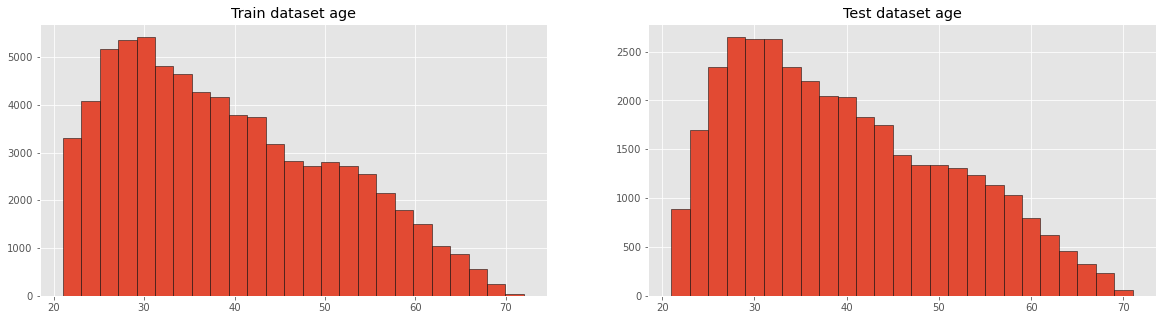

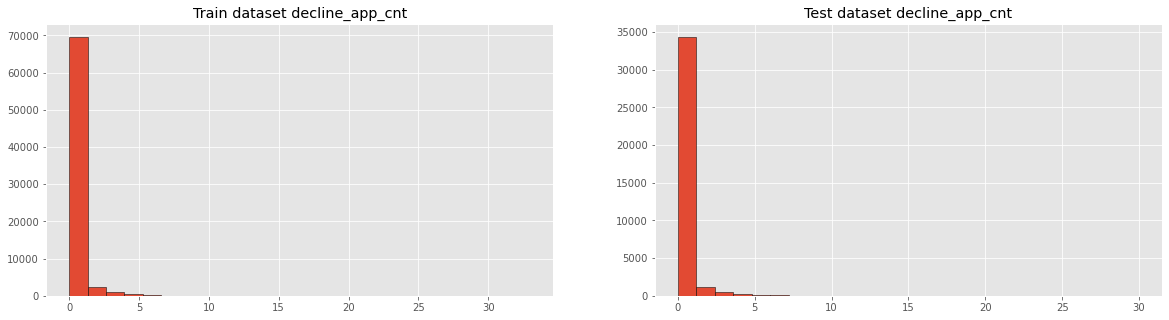

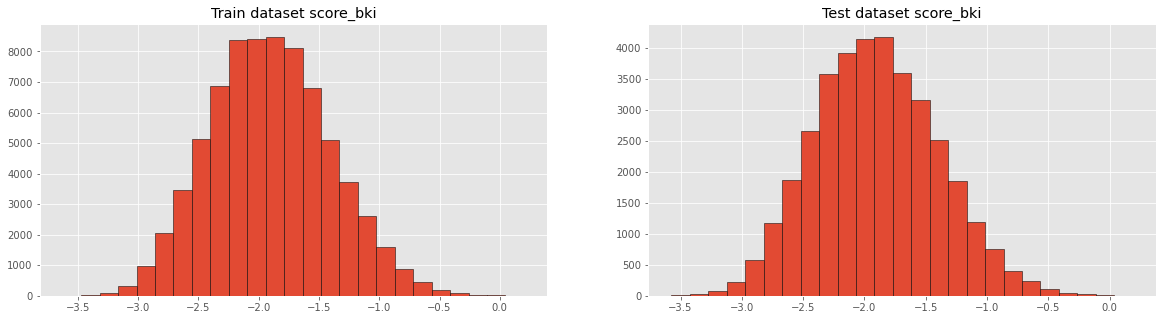

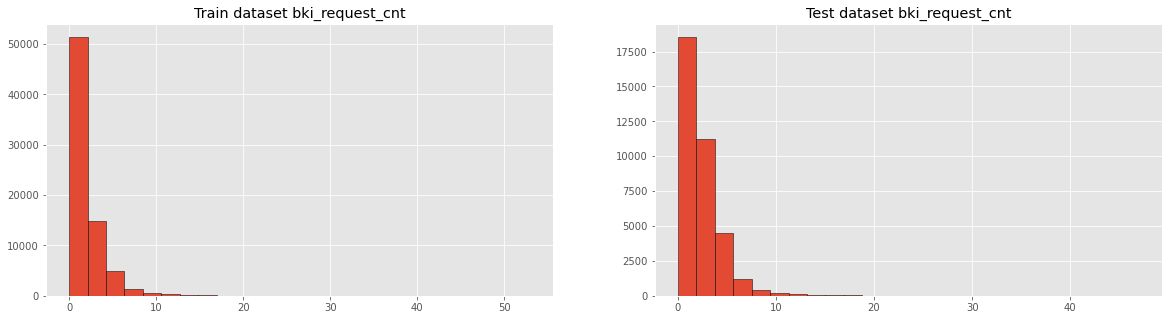

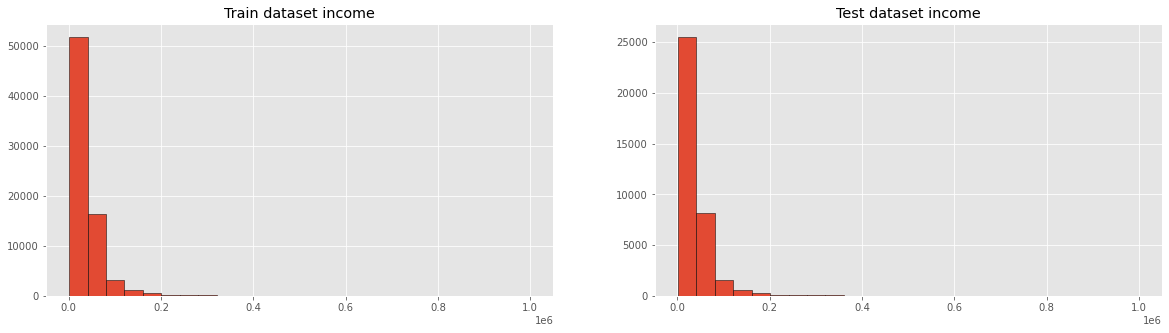

In [35]:
for col in numeric_features:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].hist(df_train[col],
                 edgecolor="black",
                 bins=25
                )
    
    axes[1].hist(df_test[col],
                 edgecolor="black",
                 bins=25
                )
    
    axes[0].set(title = ' '.join(['Train dataset', str(col)]))
    axes[1].set(title = ' '.join(['Test dataset', str(col)]))
    plt.show()

We have more aplications from people
- with scholar education (than graduated goes)
- with region rating of 50 (less - 20-30)
- with home address category of 2 (less - 3)
- with work address category of 3 (low?)
- with sna grade of 1 (of 4)
- with first_time grade of 3 (of 4)
- of female gender
- without a car
- without foreign car
- without foreign passport
- without good work
- with age of 25-30 (less - higher than 70)
- without declined applications
- with (-2.3)-(-1.7) bki score
- with up to 5 bki requests
- with less than 50,000 of income

Features with right tail:
- age
- decline_app_cnt
- bki_request_cnt
- income

### Feature patterns

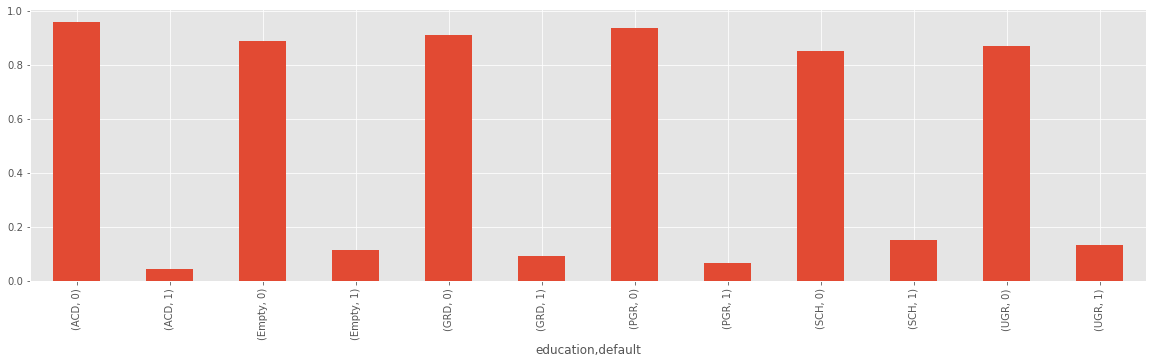

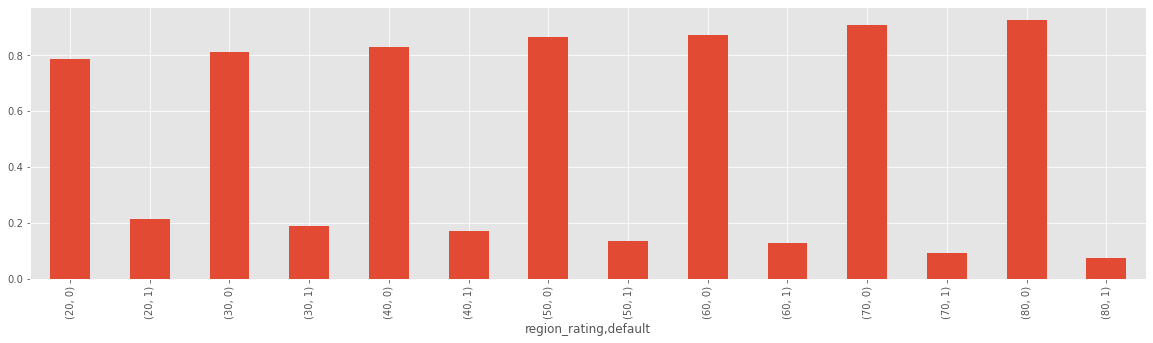

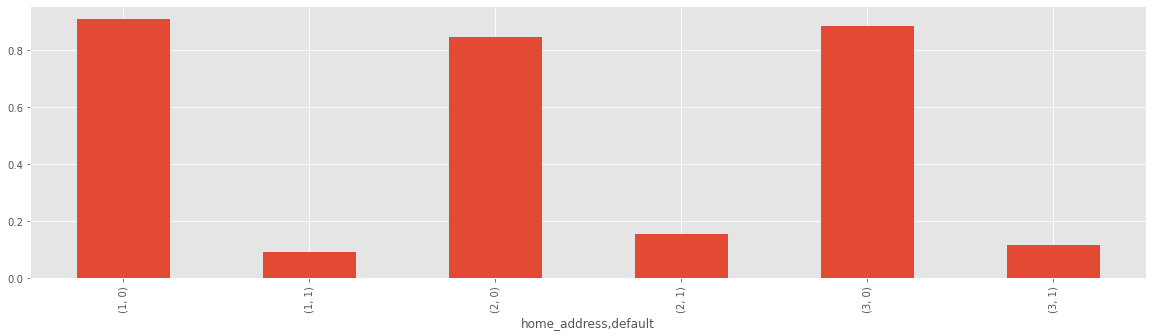

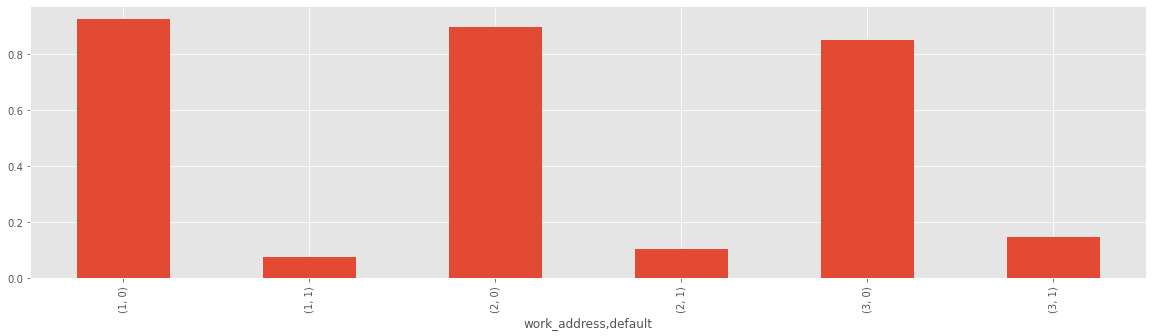

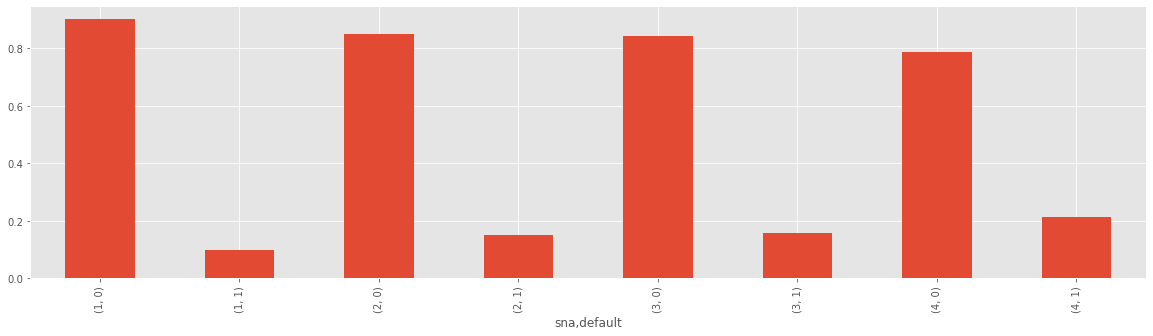

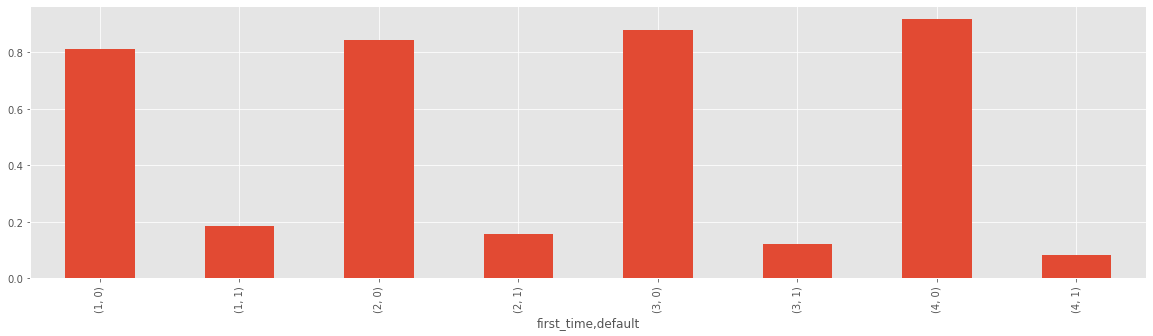

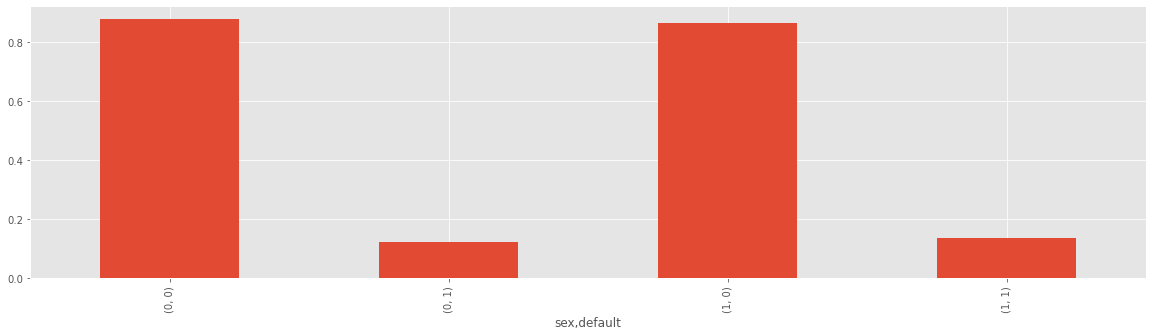

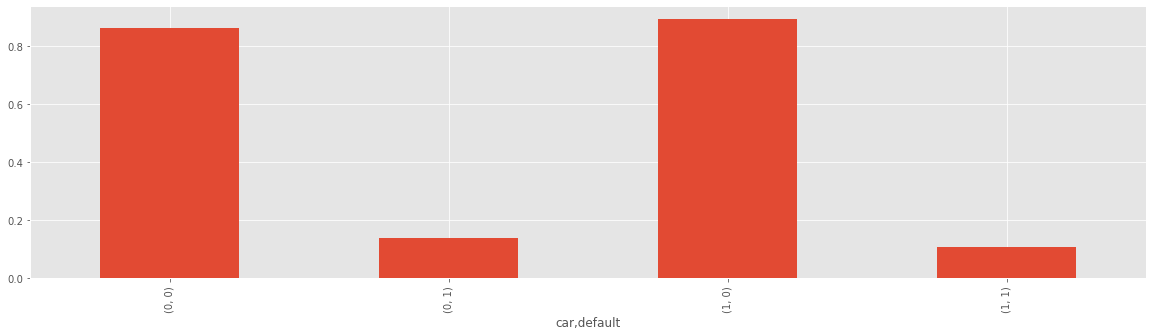

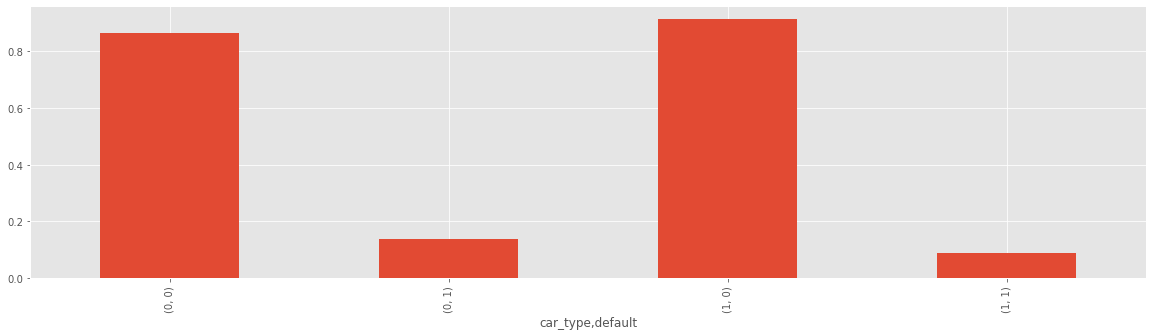

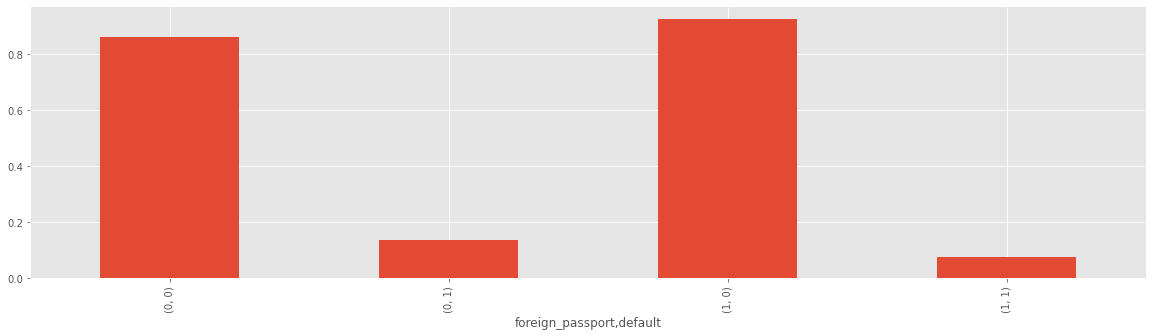

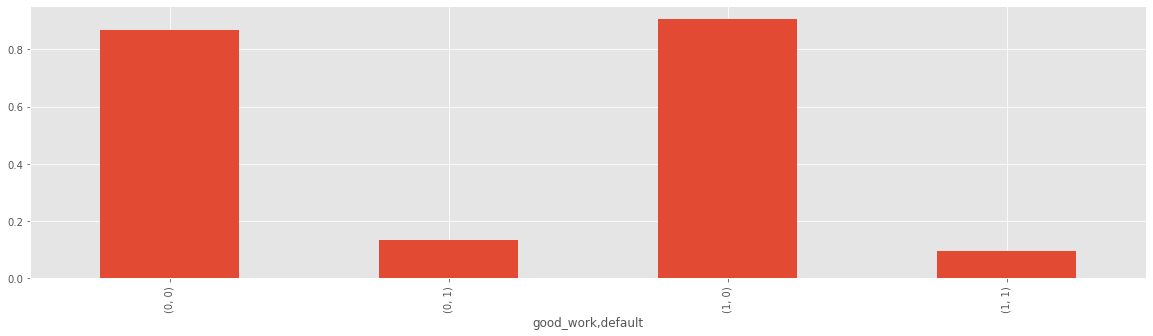

In [36]:
for col in col_list:
    df_train.groupby(col).default.value_counts(normalize=True).plot(kind='bar', figsize=(20, 5))
    plt.show()

In [37]:
def get_boxplot(data, column):
    fig, ax = plt.subplots()
    sns.boxplot(x='default', y=column, data = data)
    ax.set_title('Boxplot for ' + column)
    plt.show()

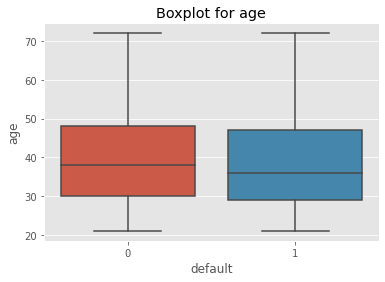

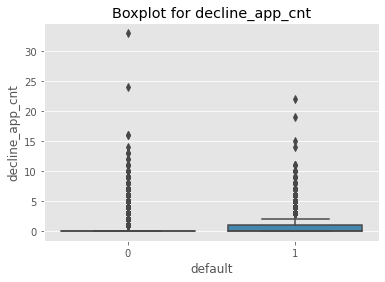

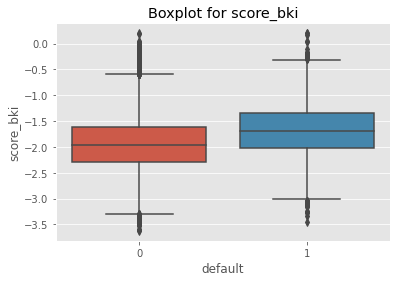

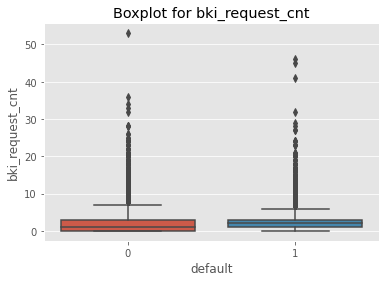

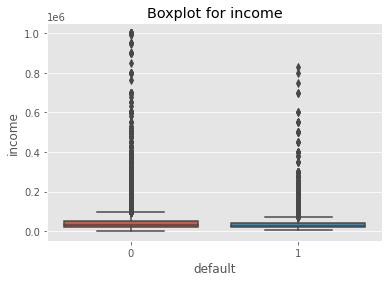

In [38]:
for col in numeric_features:
    get_boxplot(df_train, col)

Less cases of default have people:
- with academic aducation (the most - scholar)
- with region rating of 80 (the most - 20-30)
- with home address category of 1 (the most - 2)
- with work address category of 1 (the most - 3)
- with sna grade of 1 (of 4, the most - 4)
- with first_time grade of 4 (of 4, the most - 1)
- of female gender (but the difference is very small)
- with car
- with foreign car
- with foreign passport
- with good work
- who is younger but the difference is very small
- without declined applications (but a lot of outliers even the maximum value)
- with lower bki score (but the interquartile range is bigger and more outliers even the maximum & minimum values)
- with less in average bki requests (but a lot of outliers even the maximum value)
- with higher income in average but the difference is very small & there're a lot of outliers in default cases

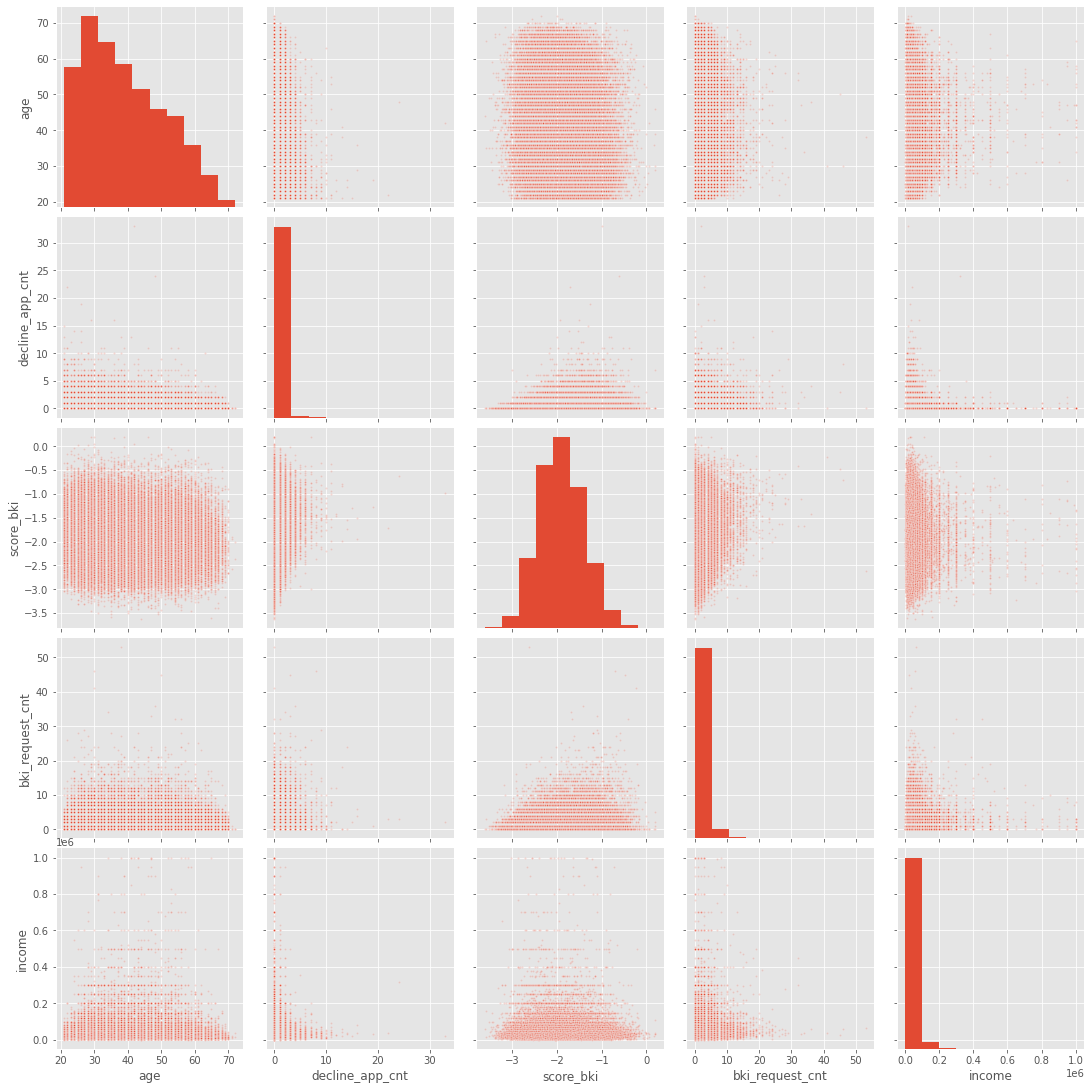

In [39]:
# Create a new dataframe which only contains the continuous features
sns.pairplot(df_train[numeric_features],
             plot_kws={"s": 5, "alpha": 0.2}, height=3)

- the higher age the less declined applications
- the higher bki score the more declined applications but not in highet cases (maybe it depends on length of credit history)
- the more bki requests the less declined applications
- the higher income the less declined applications
- the higher income the less bki requests

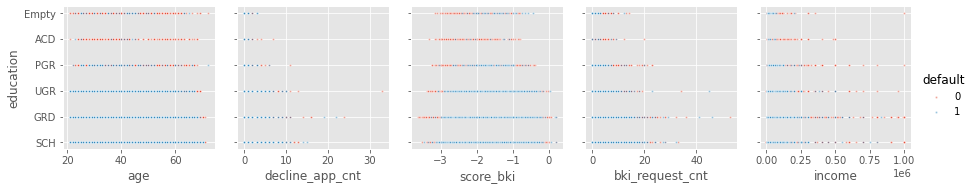

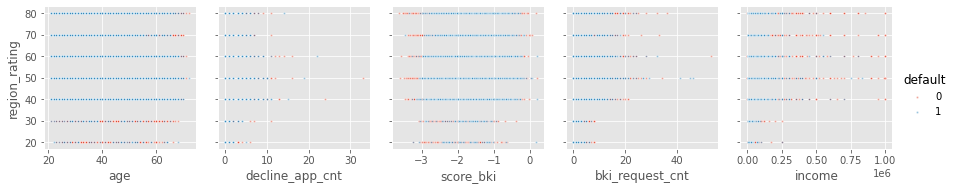

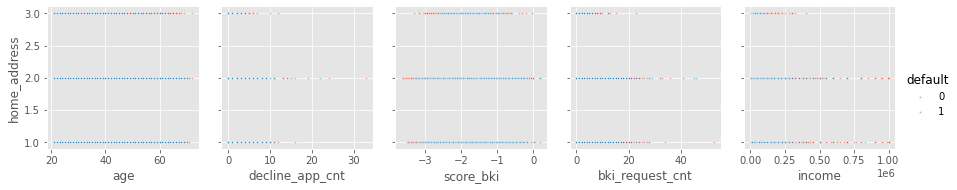

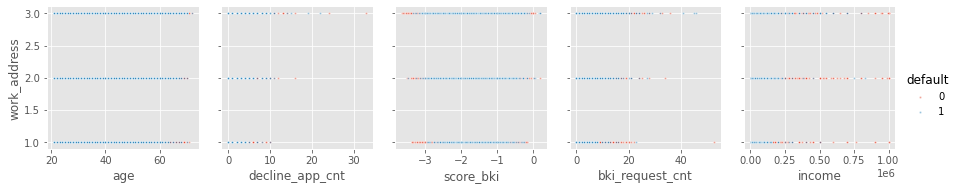

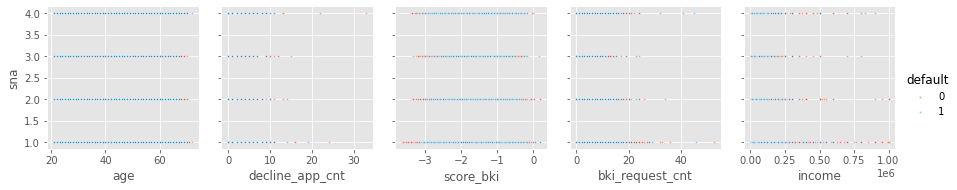

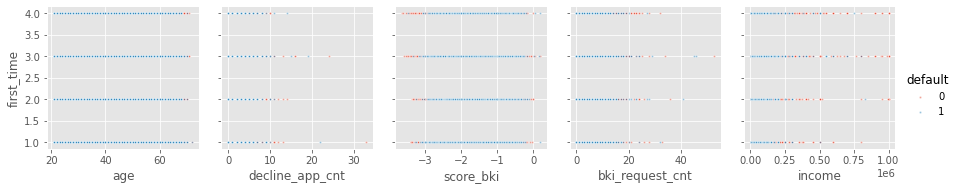

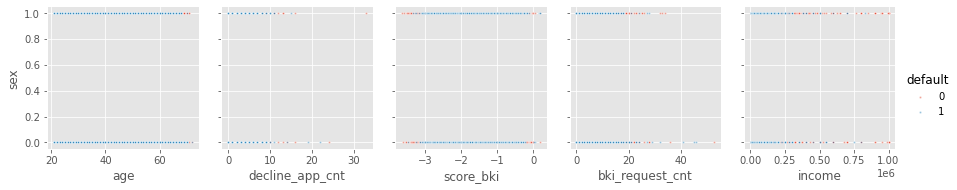

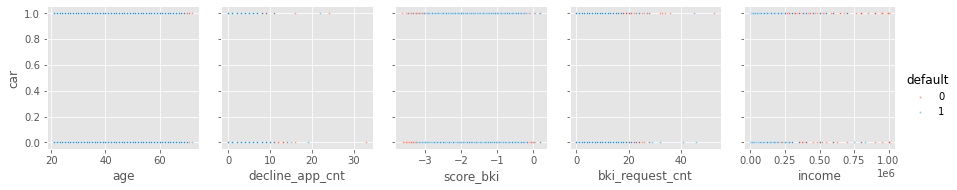

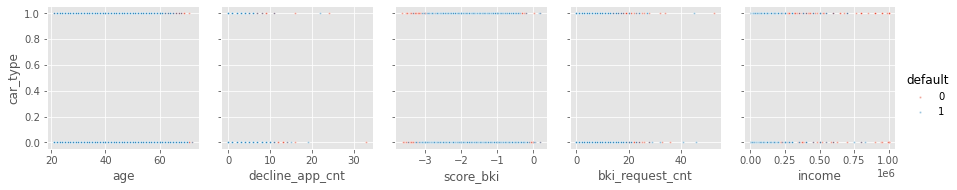

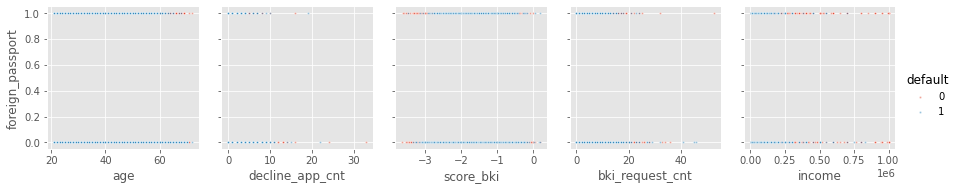

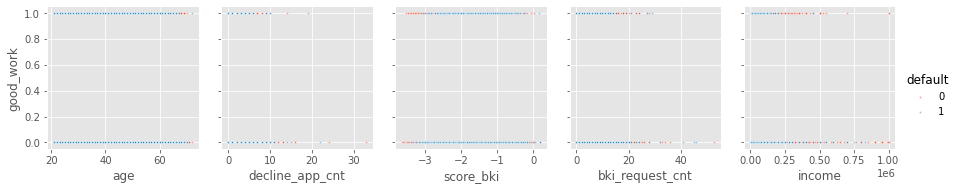

In [40]:
for col in col_list:
    sns.pairplot(
        df_train, plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=numeric_features,
        y_vars=col)
    plt.show()

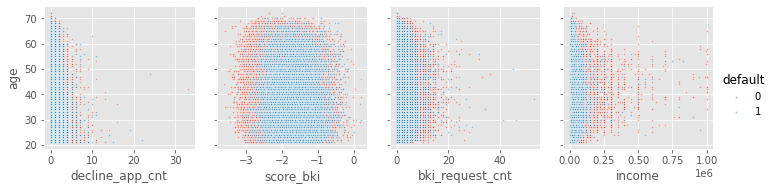

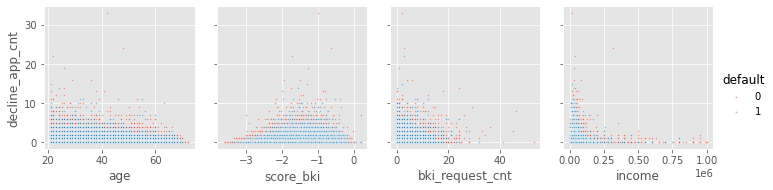

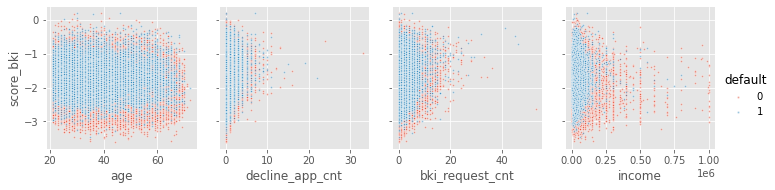

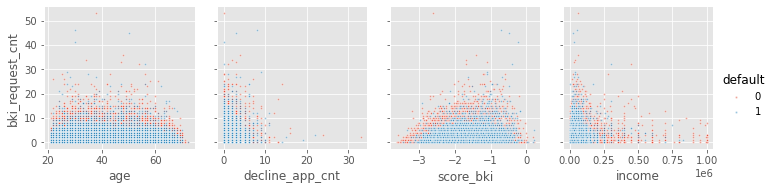

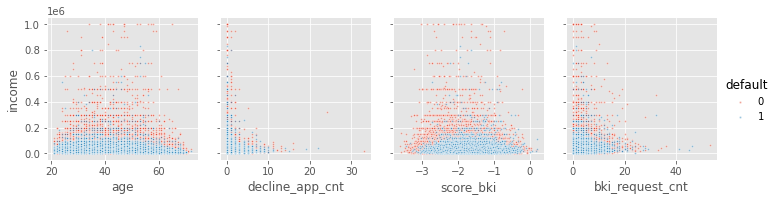

In [41]:
for col in numeric_features:
    feat_list = numeric_features.copy()
    feat_list.remove(col)
    sns.pairplot(
        df_train, plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=feat_list,
        y_vars=col)
    plt.show()

Default==0


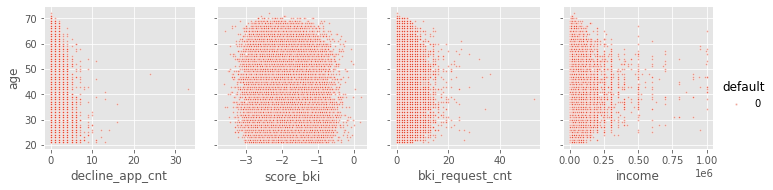

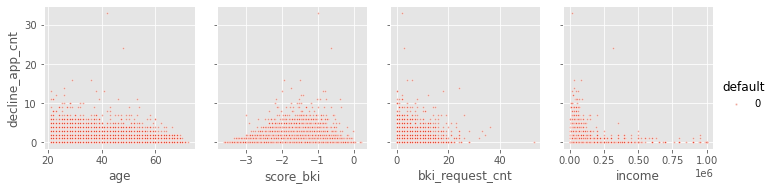

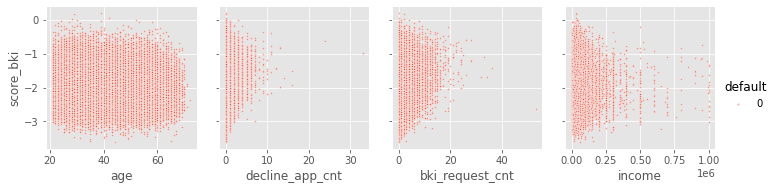

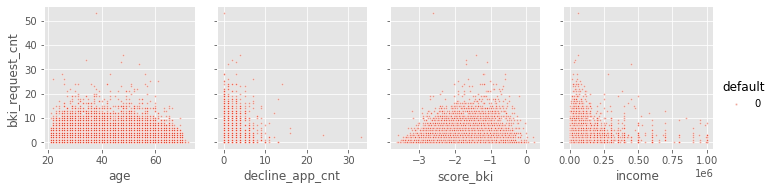

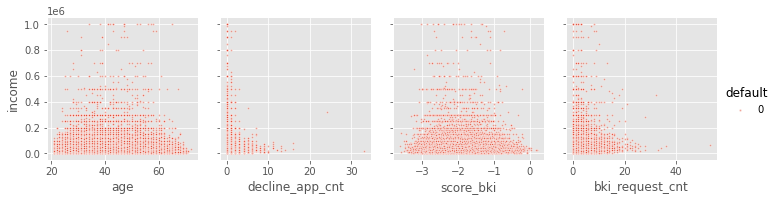

Default==1


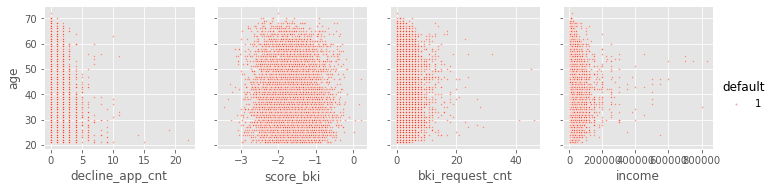

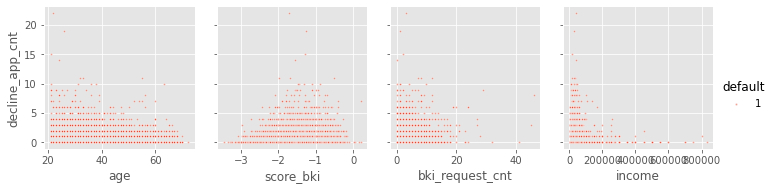

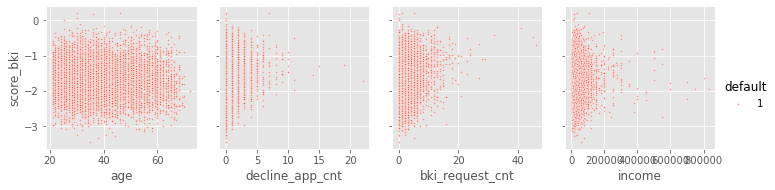

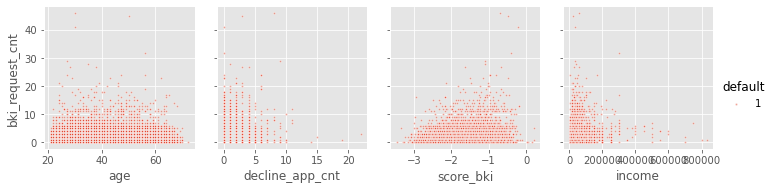

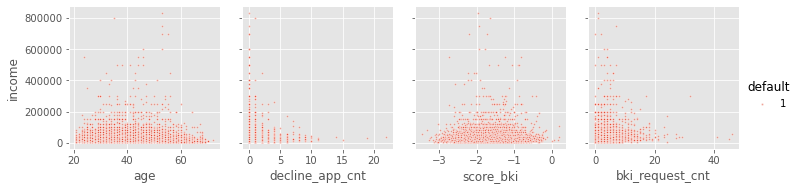

In [42]:
print('Default==0')
for col in numeric_features:
    feat_list = numeric_features.copy()
    feat_list.remove(col)
    sns.pairplot(
        df_train.query('default==0'), plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=feat_list,
        y_vars=col)
    plt.show()
    
print('Default==1')
for col in numeric_features:
    feat_list = numeric_features.copy()
    feat_list.remove(col)
    sns.pairplot(
        df_train.query('default==1'), plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=feat_list,
        y_vars=col)
    plt.show()

decline_app_cnt in train total count 73799
decline_app_cnt in train z_score outliers count 562
decline_app_cnt in train z_score outliers % 0.76

Only outliers:



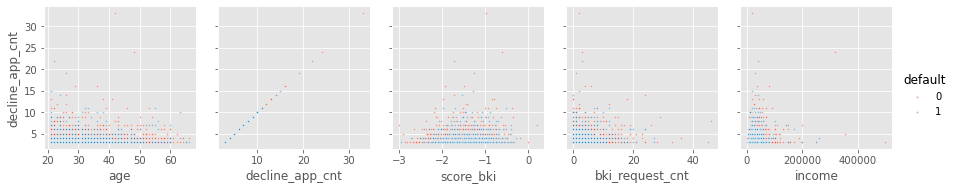

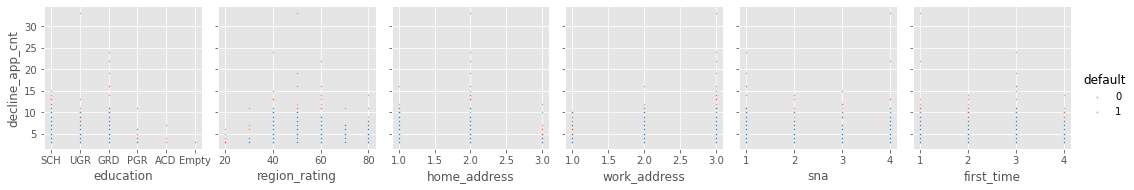

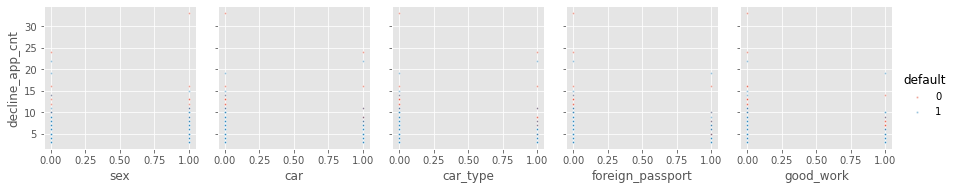

score_bki in train total count 73799
score_bki in train z_score outliers count 562
score_bki in train z_score outliers % 0.76

Only outliers:



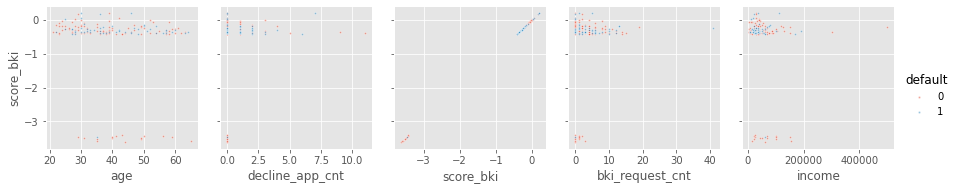

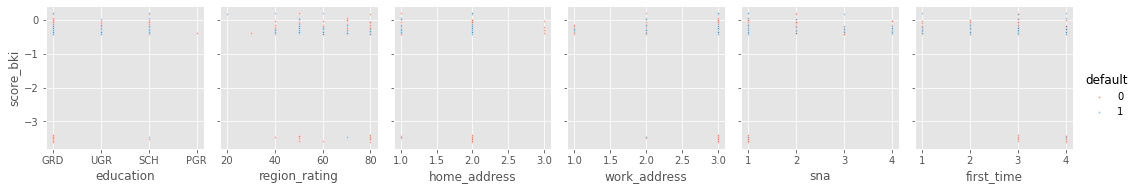

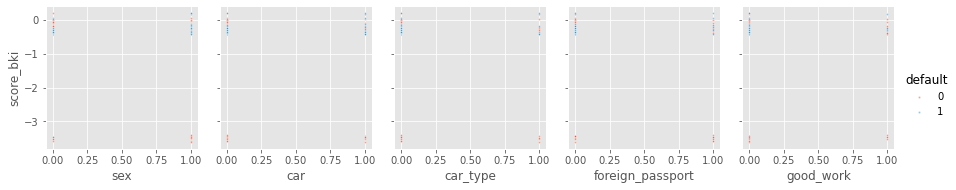

bki_request_cnt in train total count 73799
bki_request_cnt in train z_score outliers count 562
bki_request_cnt in train z_score outliers % 0.76

Only outliers:



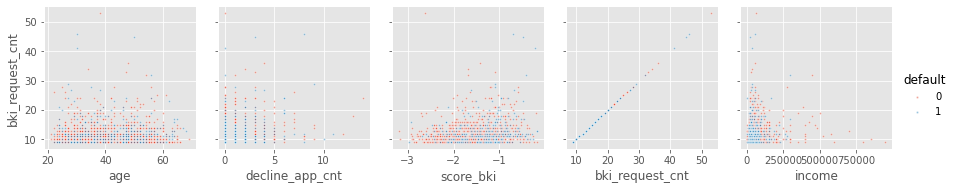

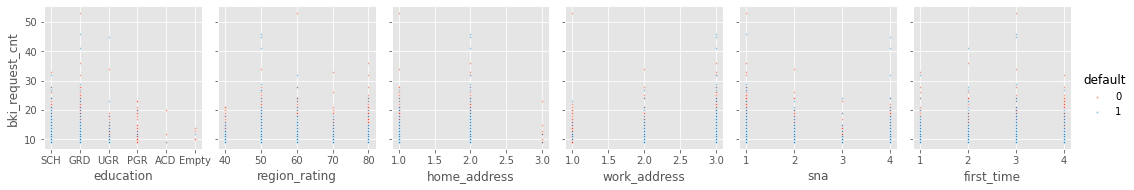

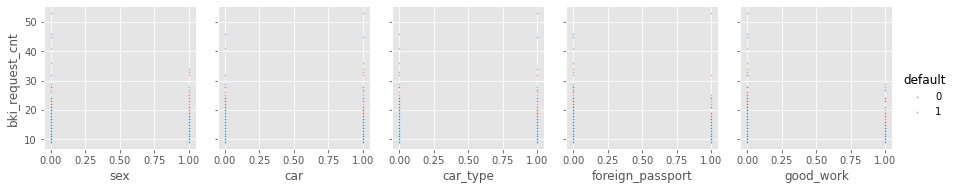

income in train total count 73799
income in train z_score outliers count 562
income in train z_score outliers % 0.76

Only outliers:



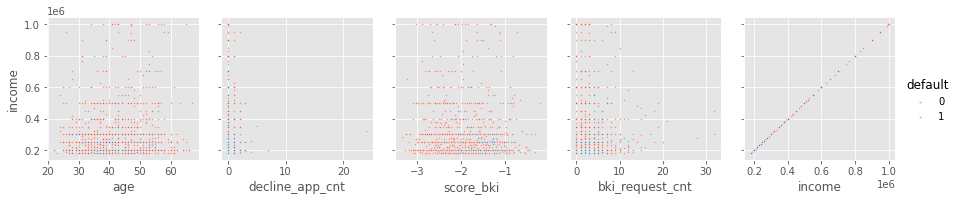

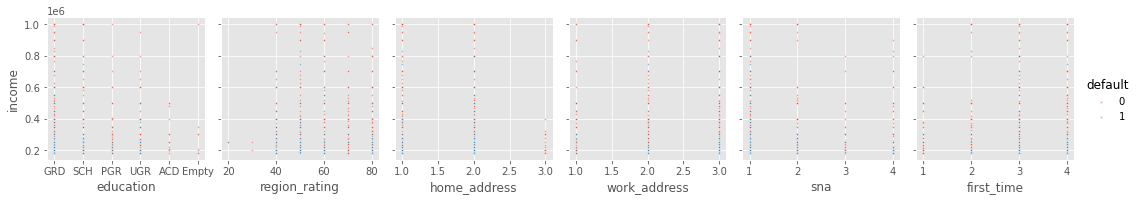

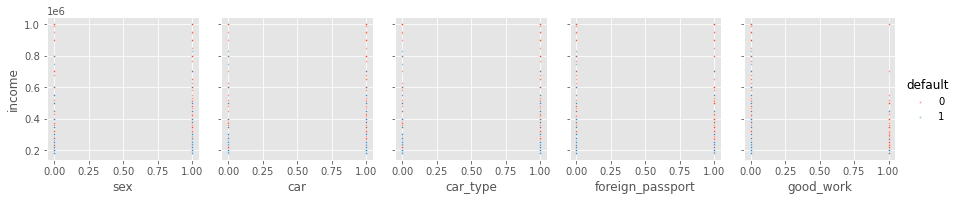

In [43]:
for col in ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']:
    df = df_train.copy()
    
    print(col, 'in train total count', df[col].count())
    
    mean_y = np.mean(df[col])
    std_y = np.std(df[col])
    z_scores = [(y - mean_y) / std_y for y in df[col]]
    df['z_scores'] = z_scores
    df['otl_z'] = df['z_scores'].apply(lambda x: 1 if np.abs(x) > 3 else 0)
    
    print(col, 'in train z_score outliers count', len(otl_z))
    print(col, 'in train z_score outliers %', round(len(otl_z)/df[col].count()*100, 2), end='\n\n')
    
    print('Only outliers:', end='\n\n')
       
    sns.pairplot(
        df.query('otl_z==1'), plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=numeric_features,
        y_vars=col)
    plt.show()
    
    sns.pairplot(
        df.query('otl_z==1'), plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=categorical_features,
        y_vars=col)
    plt.show()
    
    sns.pairplot(
        df.query('otl_z==1'), plot_kws={"s": 5, "alpha": 0.5}, hue="default", #palette="Spectral",
        x_vars=binary_features,
        y_vars=col)
    plt.show()
    

Defaults:
- age has very small impact on default, only people over 70 have the lowest number of default cases (but there're the smallest number of applications from people of this age)
- predominance of not defaults in outliers case


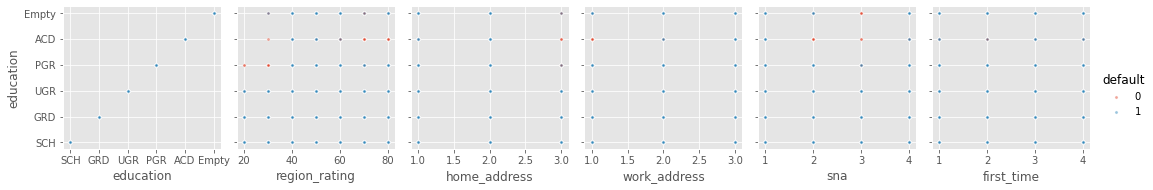

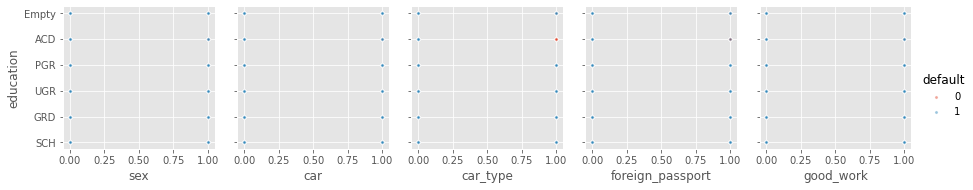

In [44]:
sns.pairplot(
    df_train, plot_kws={"s": 10, "alpha": 0.5}, hue="default", #palette="Spectral",
    x_vars=categorical_features,
    y_vars='education')
plt.show()

sns.pairplot(
    df_train, plot_kws={"s": 10, "alpha": 0.5}, hue="default", #palette="Spectral",
    x_vars=binary_features,
    y_vars='education')
plt.show()

### Feature relationships

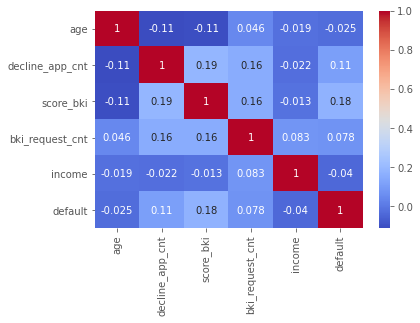

In [45]:
# Computes feature correlation
sns.heatmap(pd.concat([df_train[numeric_features], df_train['default']], axis=1).corr(method="pearson"), 
            annot=True, cmap='coolwarm')

In [46]:
education_code = {'Empty': 0,
                  'SCH': 1,
                  'UGR': 2,
                  'GRD': 3,
                  'PGR': 4,
                  'ACD': 5
                  }


df_train['education_new'] = df_train['education'].apply(lambda x: education_code[x])

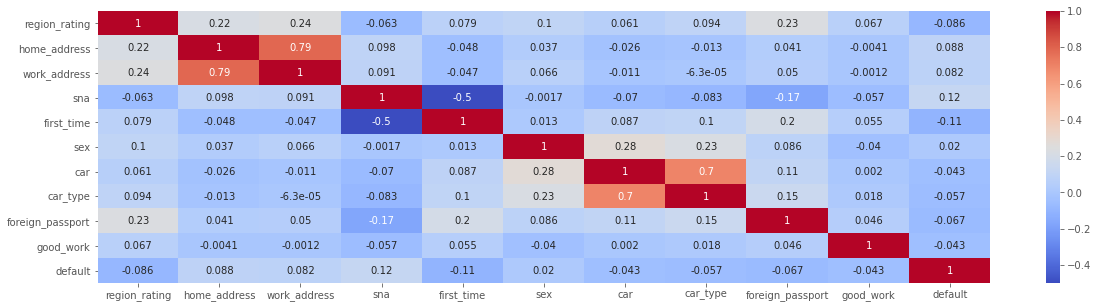

In [47]:
plt.rcParams['figure.figsize'] = (20, 5)  # figure size
# Computes feature correlation
sns.heatmap(pd.concat([df_train[col_list], df_train['default']], axis=1).corr(method="spearman"), 
            annot=True, cmap='coolwarm', )

Default (target) has linear correlation with:
- bki score (0.18)
- sna (0.12)
- declined applications (0.11)
- first time (-0.11)

Other linear correlations:
- age / declined applications & age / bki score (-0.11)
- declined applications / bki score (0.19)
- bki request / declined applications & bki request / bki score (0.16)
- home_address / work_address (0.79) -> work_address (0.088 with target vs 0.082)
- car / car_type (0.7) -> car_type (0.057 with target vs 0.043)
- sna / first time (-0.5) -> sna (0.12 with target vs -0.11)

We have gaps in education:
- numeric features/default patterns show that gaps have liklihood with ACD and PGR
- region_rating/default patterns - the same
- home_address/default - PGR
- work_address/default - not ACD
- sna/default - ACD and PGR
- correlations with: car_type, foreign_passport, good_work

In [48]:
df_train[['education', 'age', 'income']].corr(method="pearson")

age  income
age     1.0000 -0.0189
income -0.0189  1.0000

## Feature importance

### Significance of continuous variables

The capabilities of the ___sklearn.feature_selection___ module can be used not only to select important features, but also to reduce the dimensionality, improve the predictive power of models, or to increase their performance on very multidimensional datasets.

The method of estimating the significance of variables is based on ___one-factor analysis of variance (ANOVA)___. The basis of the procedure is the generalization of the results of two sample ___t-tests ___ for independent samples (2-sample t).

As a measure of significance, we will use the value of ___f-statistics___. The higher the statistic value, the less likely it is that the averages do not differ, and the more important this feature is for our linear model.

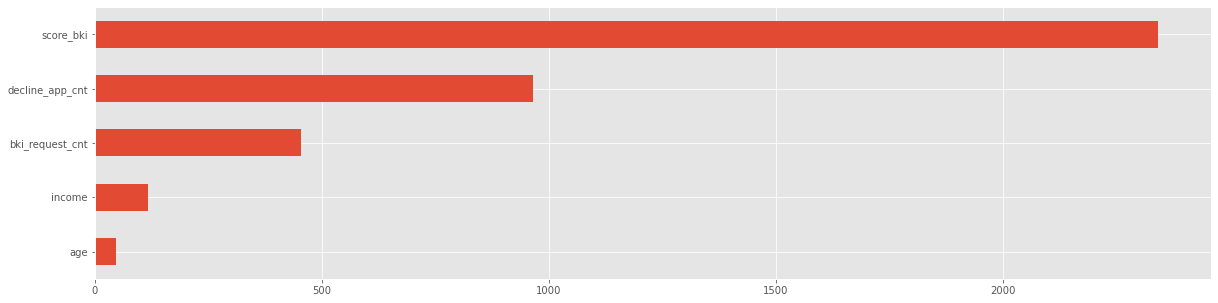

In [49]:
imp_num = Series(f_classif(df_train[numeric_features], df_train['default'])[0], index = numeric_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Significance of categorical and binary variables
To evaluate the __significance of categorical and binary variables__, we will use the ___mutual_info_classif___ function from the sklearn library. This function relies on nonparametric methods based on the estimation of entropy in groups of categorical variables.

___mutual_info_classif___ first requires categorical values to be mapped to integer values

In [50]:
categorical_features = ['education_new', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

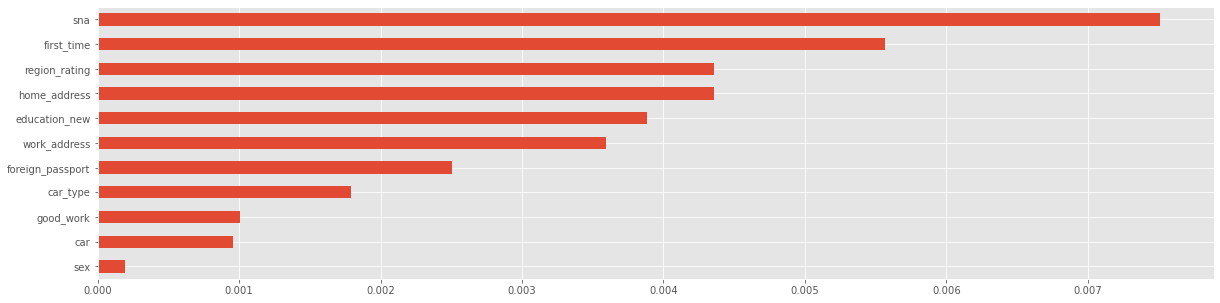

In [51]:
imp_cat = Series(mutual_info_classif(df_train[binary_features + categorical_features], df_train['default'],
                                     discrete_features =True), index = binary_features + categorical_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [52]:
df_train.drop('education_new', axis=1, inplace=True)

categorical_features = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# NaNs

We have gaps in education:
- numeric features/default patterns show that gaps have liklihood with ACD and PGR
- region_rating/default patterns - the same
- home_address/default - PGR
- work_address/default - not ACD
- sna/default - ACD and PGR
- **correlations** with: car_type, foreign_passport, good_work, income

In [53]:
import math
from scipy.stats import ttest_ind
from scipy.stats import t

from itertools import product


def t_test_diff(alpha, s_1, s_2, n_1, n_2, mean_1, mean_2, side): # left, right, dubble

    t_st = (mean_1 - mean_2) / (math.sqrt(s_1**2/n_1 + s_2**2/n_2))
    k = n_1 + n_2 - 2

    if side == 'left':
        print('T statistic is {}'.format(t_st))
        print('T critical is {}'.format(t.ppf(alpha, k)), end='\n\n')
        p_value = t.cdf(t_st, k)

    elif side == 'right':
        print('T statistic is {}'.format(t_st))
        print('T critical is {}'.format(-t.ppf(alpha, k)), end='\n\n')
        p_value = t.sf(t_st, k) # t.sf() = 1 - t.cdf()

    else:
        #t_st_list = (t_st, -t_st)
        print('T statistic is {}'.format(abs(t_st)))
        print('T critical is {}'.format(abs(t.ppf(alpha / 2, k))), end='\n\n') # !!!!!
        p_value = 2*(t.sf(abs(t_st), k)) # 1 - t.cdf(max(t_st_list)) + t.cdf(min(t_st_list))
    
    print('p_value is {}'.format(p_value))
    if p_value < alpha:
        print('H0 hypothesis at the significance level of {} is rejected in favor of H1'.format(alpha), end='\n\n')
    else:
        print('H0 hypothesis at the significance level of {} was confirmed'.format(alpha), end='\n\n')

Let's make dubble t-test to compare income in Empty education with the other education categories by each of binary features

H0 hypothesis is: mean_1 = mean_2

If it's true, we can fill up the gaps in education with according category

In [54]:
# car_type, foreign_passport, good_work & income - the highest correlations
for col in binary_features:
    print(col, end='\n\n')
    combinations = list(product(list(df_train[col].unique()), list(set(df_train.education.unique()) - set(['Empty']))))

    for comb in combinations:
        print(comb)
        mean_1, s_1, n_1 = df_train.loc[(df_train[col]==comb[0])&(df_train['education']=='Empty')].groupby('education')['income'].agg(['mean', 'std', 'count']).values[0]
        print(mean_1, s_1, n_1)
        mean_2, s_2, n_2 = df_train.loc[(df_train[col]==comb[0])&(df_train['education']==comb[1])].groupby('education')['income'].agg(['mean', 'std', 'count']).values[0]
        print(mean_2, s_2, n_2)
        #t_test_diff(0.5, s_1, s_2, n_1, n_2, mean_1, mean_2, 'dubble') # left, right, dubble

sex

(1, 'UGR')
55103.81884057971 91262.17649850521 138.0
47535.32320993128 43860.88882861962 4511.0
(1, 'ACD')
55103.81884057971 91262.17649850521 138.0
103052.17391304347 97487.32112598215 115.0
(1, 'GRD')
55103.81884057971 91262.17649850521 138.0
67486.65085638998 70714.0579525792 10626.0
(1, 'PGR')
55103.81884057971 91262.17649850521 138.0
91362.75238095238 89754.18174964044 630.0
(1, 'SCH')
55103.81884057971 91262.17649850521 138.0
39525.85324042671 35291.34888222119 16217.0
(0, 'UGR')
35947.041420118345 39852.53162484145 169.0
32467.111969839774 30517.9663626905 5305.0
(0, 'ACD')
35947.041420118345 39852.53162484145 169.0
53728.18987341772 41153.797417416325 79.0
(0, 'GRD')
35947.041420118345 39852.53162484145 169.0
43968.13054399874 44562.62546607554 12739.0
(0, 'PGR')
35947.041420118345 39852.53162484145 169.0
63667.56140350877 57519.11180990175 627.0
(0, 'SCH')
35947.041420118345 39852.53162484145 169.0
26541.780064479088 29695.990994056785 22643.0
car

(1, 'UGR')
54247.285714

**car**:
- (1, 'UGR') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.8607205013000752)

**car_type**:
- (1, 'UGR') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.5344373404957719)
- (1, 'GRD') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.9013296100260484)

**foreign_passport**:
- (0, 'UGR') - H0 hypothesis at the significance level of 0.5 was confirmed (**p_value is 0.68**43878479222265)
- (1, 'GRD') - H0 hypothesis at the significance level of 0.5 was confirmed (**p_value is 0.98**93258570458623)

**good_work**:
- (0, 'UGR') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.6586124928527306)
- (1, 'PGR') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.7826006718253138)
- (1, 'ACD') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.6500099259553406)
- (1, 'GRD') - H0 hypothesis at the significance level of 0.5 was confirmed (p_value is 0.5601307558147759)

In [55]:
df_train.education.value_counts()

SCH      38860
GRD      23365
UGR       9816
PGR       1257
Empty      307
ACD        194
Name: education, dtype: int64

In [56]:
df_test.education.value_counts()

SCH      19138
GRD      11403
UGR       4932
PGR        608
Empty      171
ACD         97
Name: education, dtype: int64

In [57]:
df_train['education'] = df_train.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)
df_test['education'] = df_test.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)

In [58]:
df_train.education.value_counts()

SCH    38860
GRD    23421
UGR    10067
PGR     1257
ACD      194
Name: education, dtype: int64

In [59]:
df_test.education.value_counts()

SCH    19138
GRD    11430
UGR     5076
PGR      608
ACD       97
Name: education, dtype: int64

In [60]:
education_code = {'SCH': 1,
                  'UGR': 2,
                  'GRD': 3,
                  'PGR': 4,
                  'ACD': 5
                  }


df_train['education'] = df_train['education'].apply(lambda x: education_code[x])

## Logarithm

Features with right tail:
- age
- decline_app_cnt
- bki_request_cnt
- income

In [61]:
def get_hists(list_of_features, df):
    
    fig, axes = plt.subplots(nrows = len(list_of_features)//2+1, ncols = 2, figsize=(20, 10))
    
    # Loop through features and put each subplot on a matplotlib axis object
    for col, ax in zip(list_of_features, axes.ravel()):

        df[col].hist(edgecolor="black", bins=100, ax=ax)
        
    plt.show()

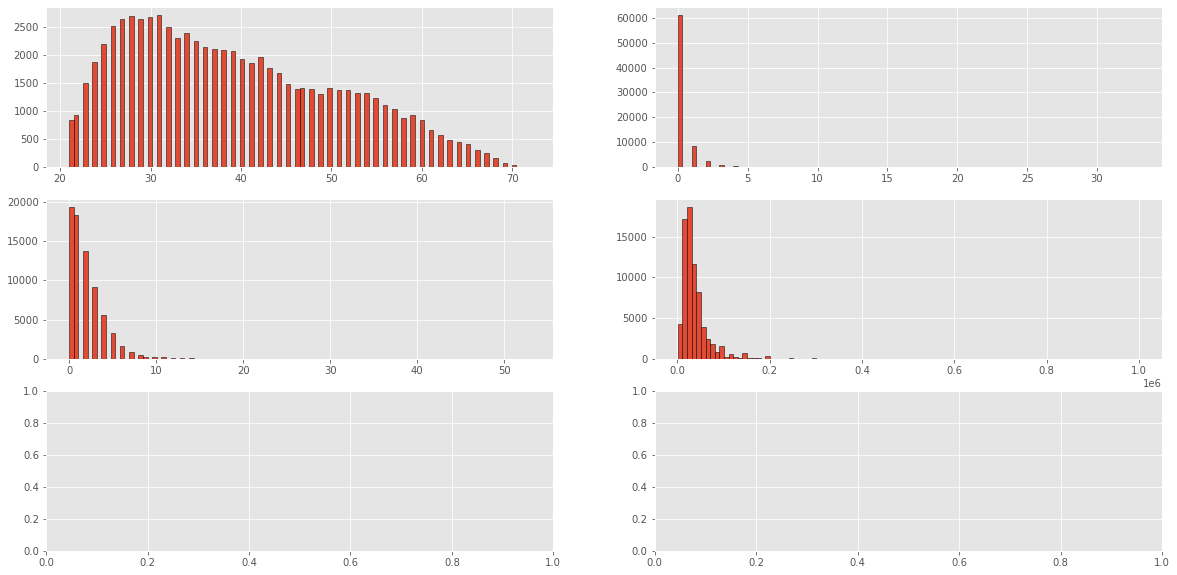

In [62]:
cols_for_norm = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
get_hists(cols_for_norm, df_train)

In [63]:
n_col = len(list(df_train.columns))

for col in cols_for_norm:
    df_train['_'.join([col, 'log'])] = df_train[col].apply(lambda x: np.log(x+1))
    
log_features = list(df_train.columns)[n_col:]
log_features

['age_log', 'decline_app_cnt_log', 'bki_request_cnt_log', 'income_log']

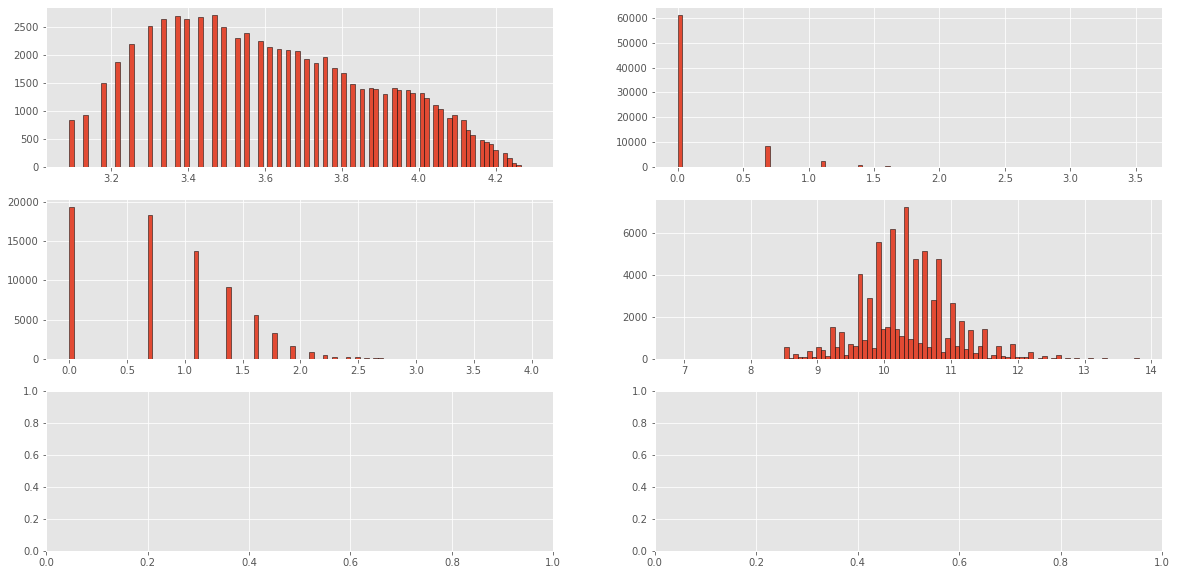

In [64]:
get_hists(log_features, df_train)

## Normaliation

In [65]:
from sklearn.preprocessing import RobustScaler

In [66]:
#norm_data = RobustScaler().fit_transform(df_train[log_features+['score_bki']].values)    # after logarithm
#norm_data = StandardScaler().fit_transform(df_train[log_features+['score_bki']].values)  # after logarithm

#norm_data = RobustScaler().fit_transform(df_train[numeric_features].values)     # without logarithm
norm_data = StandardScaler().fit_transform(df_train[numeric_features].values)   # without logarithm

norm_df = pd.DataFrame(norm_data,
                       #columns = ['_'.join([col, 'norm']) for col in cols_for_norm+['score_bki']]
                       columns = ['_'.join([col, 'norm']) for col in numeric_features]
                       )

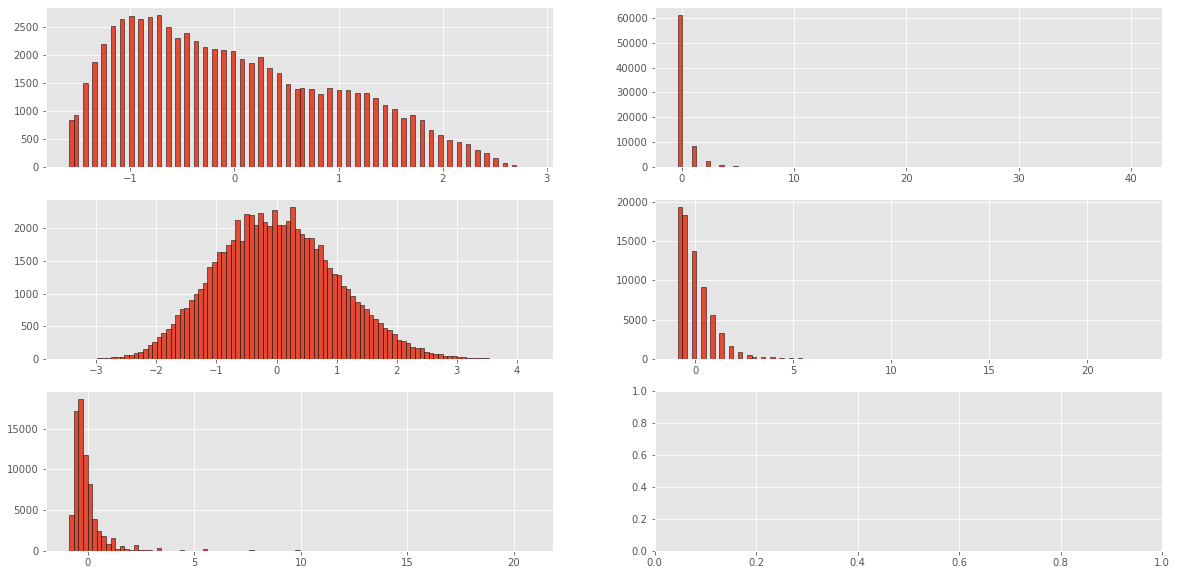

In [67]:
get_hists(list(norm_df.columns), norm_df)

In [68]:
n_col = len(list(df_train.columns))

df_train = pd.concat([df_train, norm_df], axis=1)

norm_features = list(df_train.columns)[n_col:]
norm_features

['age_norm',
 'decline_app_cnt_norm',
 'score_bki_norm',
 'bki_request_cnt_norm',
 'income_norm']

In [69]:
df_train.drop(norm_features, axis=1, inplace=True)

## Correlation

Strong correlation between variables is harmful for linear models due to the instability of the estimates obtained.

__ How to work with correlation?__

- ___Method 1.___ Select low correlated features.
- ___Method 2.___ Use regularization to penalize the model during the learning process for the complexity expressed in the magnitude of the weights, while setting the amount of the penalty. By changing this value, we will be able to control the retraining and stability of the model.

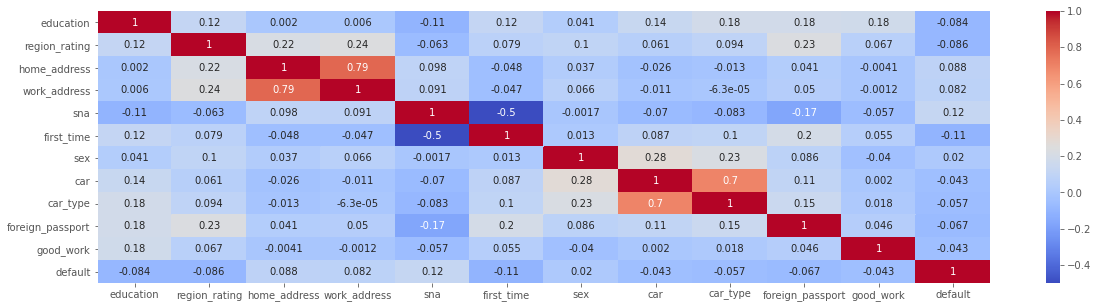

In [70]:
plt.rcParams['figure.figsize'] = (20, 5)  # figure size
# Computes feature correlation
sns.heatmap(pd.concat([df_train[categorical_features+binary_features], df_train['default']], axis=1).corr(method="spearman"), 
            annot=True, cmap='coolwarm', )

Other linear correlations:
- home_address / work_address (0.79) -> work_address (0.088 with target vs 0.082)
- car / car_type (0.7) -> car_type (0.057 with target vs 0.043)
- sna / first_time (-0.5) -> sna (0.12 with target vs -0.11)

## Outliers

outliers are possible in columns:
- decline_app_cnt - 2% of samples
- score_bki - 0.2% of samples
- bki_request_cnt - 2% of samples
- income - 1.5% of samples

In [71]:
n_col = len(list(df_train.columns))

for col in ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']:
    
    mean_y = np.mean(df_train[col])
    std_y = np.std(df_train[col])
    z_scores = [(y - mean_y) / std_y for y in df_train[col]]
    df_train['z_scores'] = z_scores
    df_train['_'.join([col, 'otl_z'])] = df_train['z_scores'].apply(lambda x: np.nan if np.abs(x) > 3 else 1)
    
    col_max_wo_otl = df_train.loc[df_train['_'.join([col, 'otl_z'])].isna()==False][col].max()
    col_min_wo_otl = df_train.loc[df_train['_'.join([col, 'otl_z'])].isna()==False][col].min()
    df_train['_'.join([col, 'new'])] = df_train.apply(lambda x: col_max_wo_otl if x['z_scores'] > 3 else (col_min_wo_otl if x['z_scores'] < -3 else x[col]), axis=1)
    
otl_z_features = list(df_train.columns)[n_col:]
otl_z_features

['z_scores',
 'decline_app_cnt_otl_z',
 'decline_app_cnt_new',
 'score_bki_otl_z',
 'score_bki_new',
 'bki_request_cnt_otl_z',
 'bki_request_cnt_new',
 'income_otl_z',
 'income_new']

In [72]:
new_features = otl_z_features[2::2]
new_features

['decline_app_cnt_new', 'score_bki_new', 'bki_request_cnt_new', 'income_new']

In [73]:
df_train[['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']+new_features].describe()

decline_app_cnt     score_bki  bki_request_cnt          income  \
count     73799.000000  73799.000000     73799.000000    73799.000000   
mean          0.275749     -1.904724         2.000339    41099.775417   
std           0.804272      0.498231         2.252073    46166.322400   
min           0.000000     -3.624586         0.000000     1000.000000   
25%           0.000000     -2.259534         0.000000    20000.000000   
50%           0.000000     -1.920823         1.000000    30000.000000   
75%           0.000000     -1.569831         3.000000    48000.000000   
max          33.000000      0.199773        53.000000  1000000.000000   

       decline_app_cnt_new  score_bki_new  bki_request_cnt_new     income_new  
count         73799.000000   73799.000000         73799.000000   73799.000000  
mean              0.227280      -1.904988             1.929714   39169.486822  
std               0.537703       0.497235             1.906677   31183.201579  
min               0.000000      -3.398822             0.000000    1000.000000  
25%               0.000000      -2.259534             0.000000   20000.000000  
50%               0.000000      -1.920823             1.000000   30000.000000  
75%               0.000000      -1.569831             3.000000   48000.000000  
max               2.000000      -0.410704             8.000000  176620.000000

In [74]:
print('log_features:', log_features)

log_features: ['age_log', 'decline_app_cnt_log', 'bki_request_cnt_log', 'income_log']


In [75]:
n_col = len(list(df_train.columns))

new_features_for_log = new_features.copy()
new_features_for_log.remove('score_bki_new')

for col in new_features_for_log:
    df_train['_'.join([col, 'log'])] = df_train[col].apply(lambda x: np.log(x+1))
    
new_log_features = list(df_train.columns)[n_col:]
print('log_features:', log_features)
print('new_features:', new_features)
print('new_log_features', new_log_features)

log_features: ['age_log', 'decline_app_cnt_log', 'bki_request_cnt_log', 'income_log']
new_features: ['decline_app_cnt_new', 'score_bki_new', 'bki_request_cnt_new', 'income_new']
new_log_features ['decline_app_cnt_new_log', 'bki_request_cnt_new_log', 'income_new_log']


In [76]:
col_for_model = binary_features + categorical_features + new_log_features + ['age_log','score_bki_new', 'default']
col_for_model

['sex',
 'car',
 'car_type',
 'foreign_passport',
 'good_work',
 'education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'decline_app_cnt_new_log',
 'bki_request_cnt_new_log',
 'income_new_log',
 'age_log',
 'score_bki_new',
 'default']

In [77]:
df_train.drop(otl_z_features+new_log_features, axis=1, inplace=True)
len(list(df_train.columns))

# 22 - 16 = 8 (4: not log, 2: 'add_date', 'default')

22

## Dates

In [78]:
print(df_train.app_date.tolist()[0], type(df_train.app_date.tolist()[0]))
df_train.app_date.describe()

01FEB2014 <class 'str'>


count         73799
unique          120
top       18MAR2014
freq           1018
Name: app_date, dtype: object

In [79]:
df_train['app_date'] = df_train['app_date'].dropna().apply(lambda x: pd.to_datetime(x))
print(df_train.app_date.tolist()[0], type(df_train.app_date.tolist()[0]))
df_train.app_date.describe()

2014-02-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


count                   73799
unique                    120
top       2014-03-18 00:00:00
freq                     1018
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

In [80]:
max_date = max(df_train.app_date.tolist())
df_train['app_date_max_dlt'] = df_train['app_date'].dropna().apply(lambda x: (max_date - x).days)
print(df_train.app_date_max_dlt.tolist()[0], type(df_train.app_date_max_dlt.tolist()[0]))
df_train.app_date_max_dlt.describe()

88 <class 'int'>


count    73799.000000
mean        57.964566
std         32.121884
min          0.000000
25%         30.000000
50%         57.000000
75%         86.000000
max        119.000000
Name: app_date_max_dlt, dtype: float64

In [81]:
df_train['app_date_day'] = df_train['app_date'].dropna().apply(lambda x: x.day)
df_train['app_date_month'] = df_train['app_date'].dropna().apply(lambda x: x.month)
df_train[['app_date_day', 'app_date_month']].describe()

app_date_day  app_date_month
count  73799.000000    73799.000000
mean      15.966517        2.537053
std        8.602978        1.089098
min        1.000000        1.000000
25%        9.000000        2.000000
50%       16.000000        3.000000
75%       23.000000        3.000000
max       31.000000        4.000000

In [82]:
df_train['app_date_dow'] = df_train['app_date'].dropna().apply(lambda x: x.dayofweek)
df_train['app_date_w_end'] = df_train['app_date_dow'].dropna().apply(lambda x: 1 if x in [5, 6] else 0)
df_train[['app_date_dow', 'app_date_w_end']].describe()

app_date_dow  app_date_w_end
count  73799.000000    73799.000000
mean       2.672231        0.202997
std        1.897352        0.402233
min        0.000000        0.000000
25%        1.000000        0.000000
50%        3.000000        0.000000
75%        4.000000        0.000000
max        6.000000        1.000000

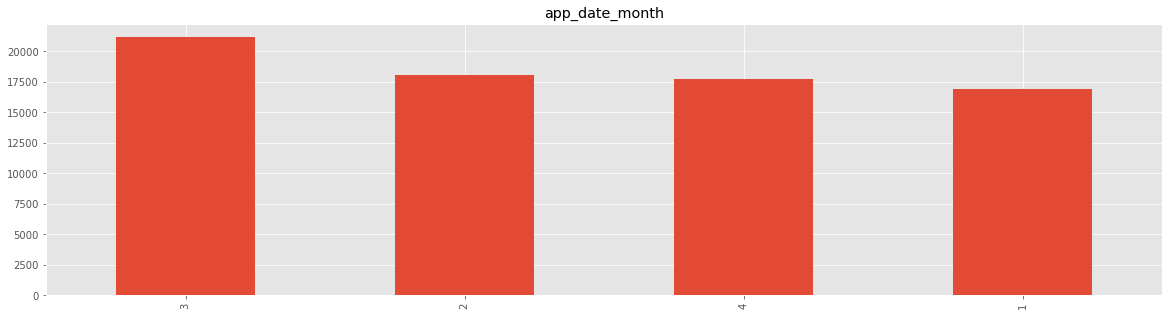

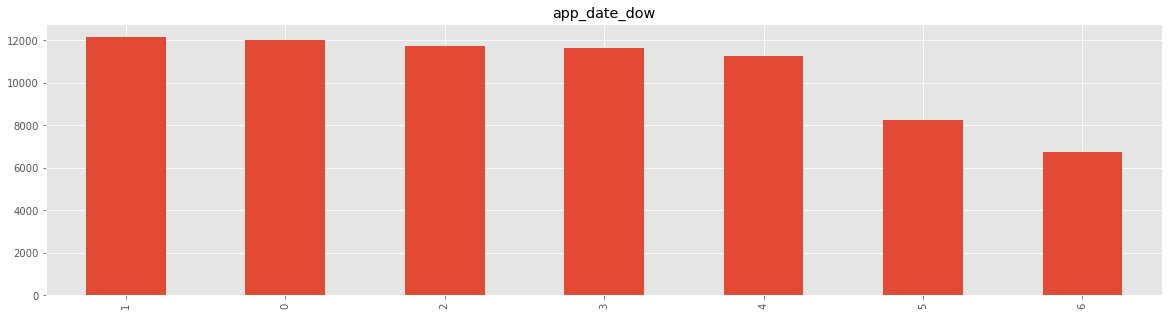

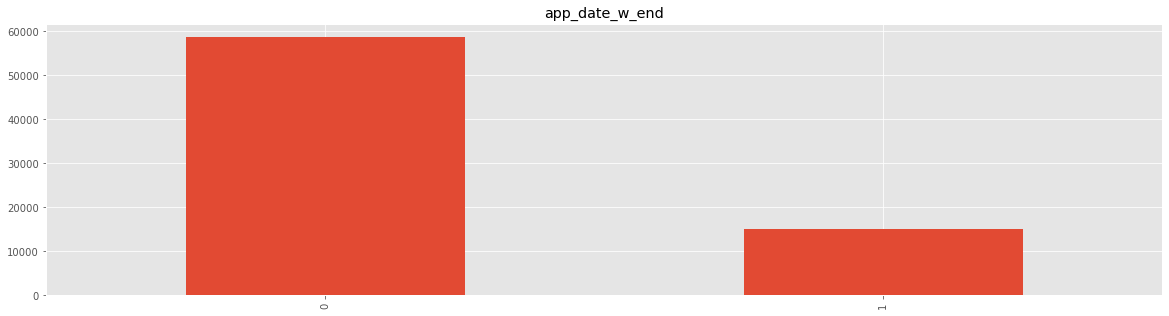

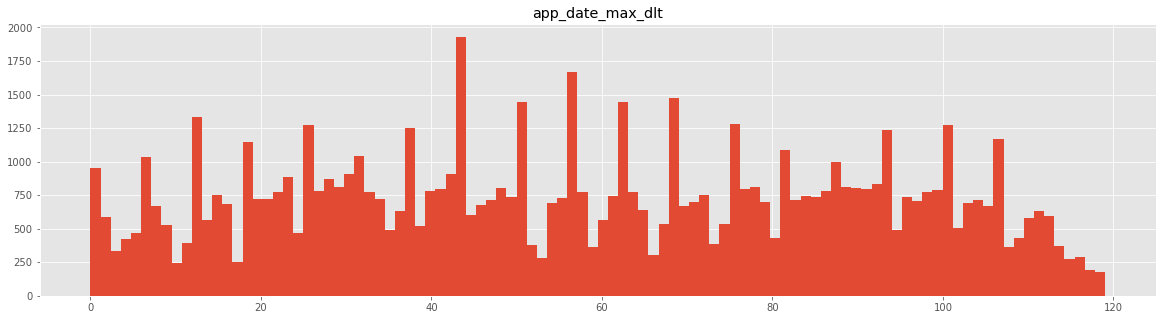

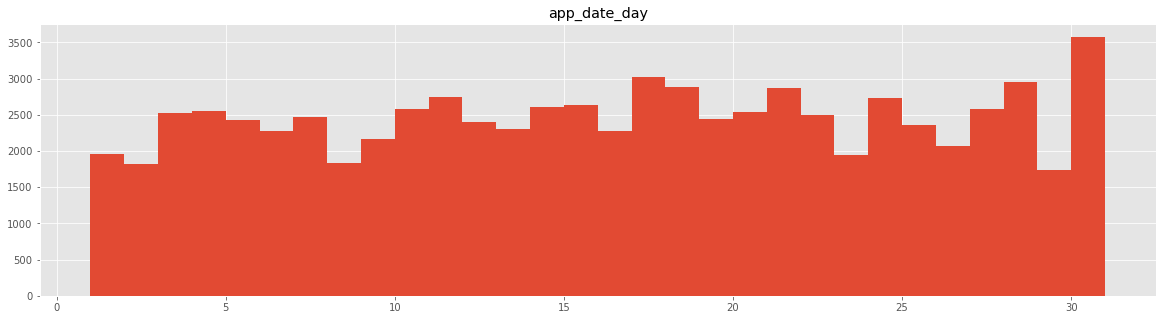

In [83]:
for col in ['app_date_month', 'app_date_dow', 'app_date_w_end']:
    df_train[col].value_counts().plot.bar(title=col)
    plt.show()

#for col in ['app_date_max_dlt', 'app_date_day']:
df_train['app_date_max_dlt'].hist(bins=100)
plt.title('app_date_max_dlt')
plt.show()
    
df_train['app_date_day'].hist(bins=30)
plt.title('app_date_day')
plt.show()

Applications are submited the most:
- in march
- on Tuesdays
- on working days
- at the end of the month
- cyclicity is present

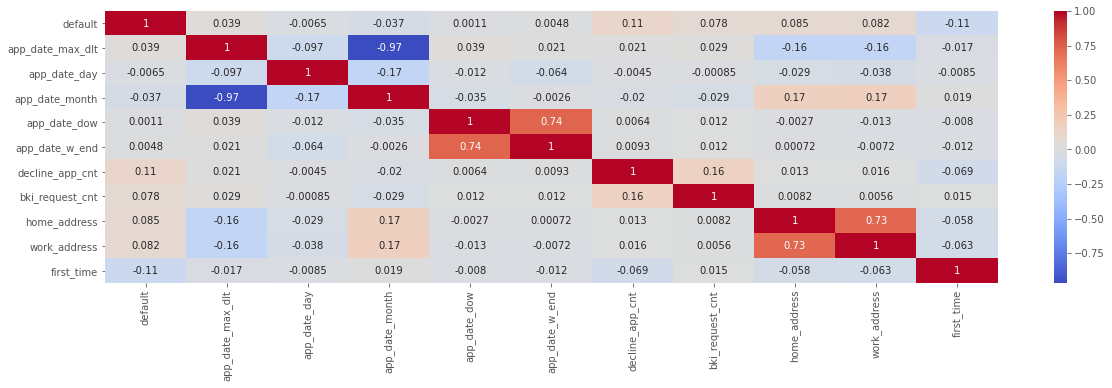

In [84]:
plt.rcParams['figure.figsize'] = (20, 5)
sns.heatmap(df_train[['default', 'app_date_max_dlt', 'app_date_day', 'app_date_month', 'app_date_dow', 'app_date_w_end', 'decline_app_cnt', 'bki_request_cnt', 'home_address', 'work_address', 'first_time']].corr(),
            annot=True, cmap='coolwarm')

Linear correlation with default is not significant.

Other linear correlations:
- app_date_month / home_address & work_address (0.17)
- app_date_max_dlt / app_date_month (-0.97) -> app_date_max_dlt (0.039 with target vs -0.037)
- app_date_dow / app_date_w_end (0.74) -> app_date_w_end (0.0048 with target vs 0.0011)

In [85]:
df = pd.DataFrame(df_train[['app_date', 'app_date_max_dlt']].copy().groupby('app_date').app_date_max_dlt.mean())
df.head()

app_date_max_dlt
app_date                    
2014-01-01               119
2014-01-02               118
2014-01-03               117
2014-01-04               116
2014-01-05               115

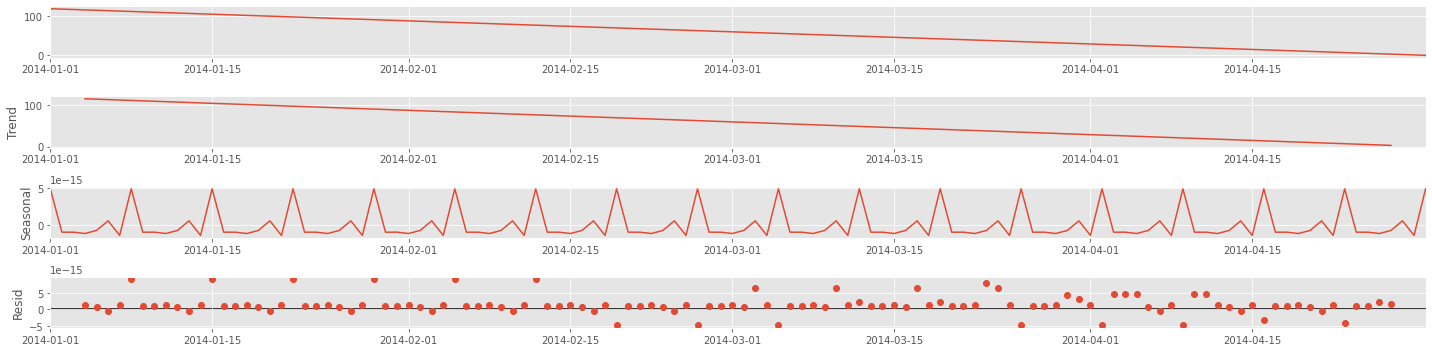

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

In [87]:
trend_dict = decomposition.trend.to_dict()
season_dict = decomposition.seasonal.to_dict()
resid_dict = decomposition.resid.to_dict()

In [88]:
df_train['app_date_trend'] = df_train['app_date'].dropna().apply(lambda x: trend_dict[x])
df_train['app_date_season'] = df_train['app_date'].dropna().apply(lambda x: season_dict[x])
df_train['app_date_resid'] = df_train['app_date'].dropna().apply(lambda x: resid_dict[x])

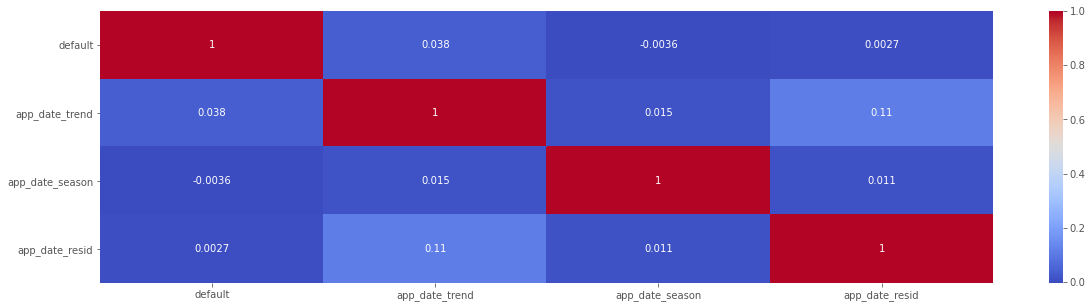

In [89]:
sns.heatmap(df_train[['default', 'app_date_trend', 'app_date_season', 'app_date_resid']].corr(),
            annot=True, cmap='coolwarm')

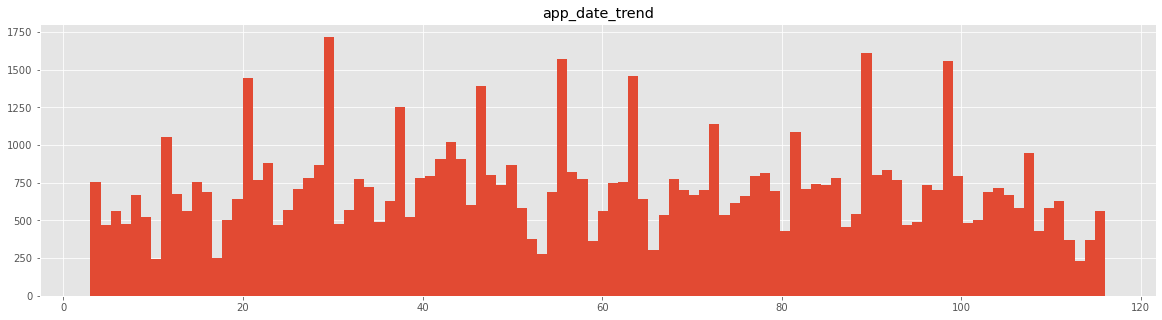

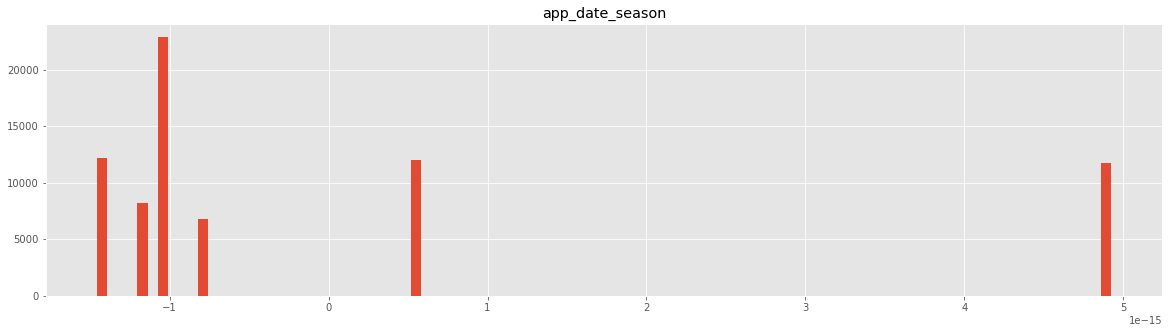

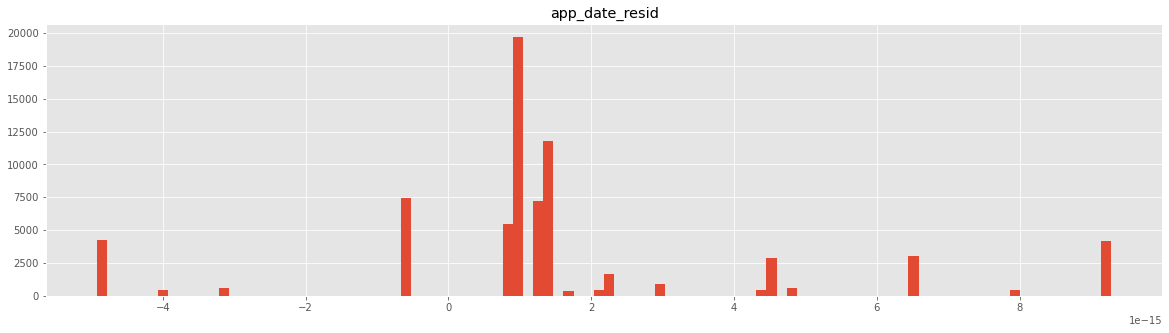

In [90]:
for col in ['app_date_trend', 'app_date_season', 'app_date_resid']:
    df_train[col].hist(bins=100)
    plt.title(col)
    plt.show()

## Dummy

In [91]:
binary_features.append('app_date_w_end')
print('binary_features count:', len(binary_features))

categorical_features.extend(['app_date_month', 'app_date_dow'])
print('categorical_features count:', len(categorical_features))

numeric_features.extend(['app_date_max_dlt', 'app_date_day'])
print('numeric_features count:', len(numeric_features))

binary_features count: 6
categorical_features count: 8
numeric_features count: 7


In [92]:
X_cat = df_train[categorical_features].values
print('X_cat shape:', np.shape(X_cat))

X_bin = df_train[binary_features].values
print('X_bin shape:', np.shape(X_bin))

X_num = df_train[log_features+['score_bki', 'app_date_max_dlt', 'app_date_day']].values
print('X_num shape:', np.shape(X_num))

X_dum = OneHotEncoder(sparse = False).fit_transform(df_train[categorical_features].values)
print('X_dum shape:', np.shape(X_dum))

X_cat shape: (73799, 8)
X_bin shape: (73799, 6)
X_num shape: (73799, 7)
X_dum shape: (73799, 37)


# Preprocessing

In [93]:
# DATA

DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


# fill up gaps in education with Empty for now
df_train.education = df_train.education.fillna('Empty')
df_test.education = df_test.education.fillna('Empty')


# all client_id are unique
df_train.drop('client_id', axis=1, inplace=True)
df_test.drop('client_id', axis=1, inplace=True)


binary_features = ['sex', 'car', 'car_type', 'foreign_passport'] # good_work, default (target)
label_encoder = LabelEncoder()
labels_dict = {}

for col in binary_features:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_test[col] = label_encoder.transform(df_test[col])
    labels_dict.setdefault(str(col), dict(enumerate(label_encoder.classes_)))

binary_features = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work'] # default (target)
categorical_features = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
date_features = ['app_date']
numeric_features = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']



# NaNs

df_train['education'] = df_train.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)
df_test['education'] = df_test.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)

education_code = {'SCH': 1,
                  'UGR': 2,
                  'GRD': 3,
                  'PGR': 4,
                  'ACD': 5
                  }

df_train['education'] = df_train['education'].apply(lambda x: education_code[x])



# Logarithm

cols_for_norm = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

n_col = len(list(df_train.columns))

for col in cols_for_norm:
    df_train['_'.join([col, 'log'])] = df_train[col].apply(lambda x: np.log(x+1))
    
log_features = list(df_train.columns)[n_col:]



# Date

df_train['app_date'] = df_train['app_date'].dropna().apply(lambda x: pd.to_datetime(x))

max_date = max(df_train.app_date.tolist())
df_train['app_date_max_dlt'] = df_train['app_date'].dropna().apply(lambda x: (max_date - x).days)
df_train['app_date_day'] = df_train['app_date'].dropna().apply(lambda x: x.day)
df_train['app_date_month'] = df_train['app_date'].dropna().apply(lambda x: x.month)
df_train['app_date_dow'] = df_train['app_date'].dropna().apply(lambda x: x.dayofweek)
df_train['app_date_w_end'] = df_train['app_date_dow'].dropna().apply(lambda x: 1 if x in [5, 6] else 0)



# Dummy

binary_features.append('app_date_w_end')
categorical_features.extend(['app_date_month', 'app_date_dow'])
numeric_features.extend(['app_date_max_dlt', 'app_date_day'])

X_cat = df_train[categorical_features].values
X_dum = OneHotEncoder(sparse = False).fit_transform(df_train[categorical_features].values)

X_bin = df_train[binary_features].values
X_num = df_train[log_features+['score_bki', 'app_date_max_dlt', 'app_date_day']].values



# Model

Our first model on raw data:
- roc_auc = 0.584
- f1_score = 0.0
- doesn't recognise any default cases

What to do next:
- fill gaps in education (roc_auc = 0.584)
- logarithm needed features (roc_auc = 0.739, f1_score = 0.0367)
- normalise with logarithm needed features
    - RobustScaer (roc_auc = 0.738, f1_score = 0.0396)
    - StandardScaler (roc_auc = 0.738, f1_score = 0.0396)
- normalise without logarithm needed features
    - RobustScaer (roc_auc = 0.736, f1_score = 0.0394)
    - StandardScaler (roc_auc = 0.736, f1_score = 0.0375)
    -> will try to fix via hyperparameters
- work with correlations
    - with logarithm (roc_auc = 0.735, f1_score = 0.0386)
    -> will try to fix via hyperparameters
- work with outliers
    - without outliers by z-score & logarithm (roc_auc = 0.728, f1_score = 0.0176)
    - max or min without outliers by z-score instead of outliers & logarithm (roc_auc = 0.739, f1_score = 0.0325)
- categorical -> dummy with logarithm (roc_auc = 0.742, f1_score = 0.0427)
- work with dates 
    - categorical -> dummy with logarithm (roc_auc = 0.745, f1_score = 0.0437)
    - split with stratify = y (roc_auc = 0.736, f1_score = 0.0589)
- work with undersampling

In [94]:
#X = df_train.copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[binary_features+categorical_features+norm_features+['default']].copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[binary_features+categorical_features+log_features+['score_bki', 'default']].copy().select_dtypes(include='number').drop(['home_address', 'car', 'first_time', 'default'], axis=1)
#X = df_wo_otl[binary_features+categorical_features+log_features+['score_bki', 'default']].copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[col_for_model].copy().select_dtypes(include='number').drop('default', axis=1)

# the best for now
# binary_features + categorical_features (dummy) + log_features + ['score_bki', 'app_date_max_dlt', 'app_date_day']
X = np.hstack([X_num, X_bin, X_dum])

print('X shape:', X.shape)
y = df_train['default'].copy()
print('y shape:', y.shape)

# X shape: (73799, 16)
# y shape: (73799,)

X shape: (73799, 50)
y shape: (73799,)


In [95]:
def get_roc_auc(X, y, model):
    y_pred_prob = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)

    fpr, tpr, threshold = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    #preds = model.predict(X)
    print('F1: %.4f' % f1_score(y, y_pred))
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_pred).T)
    #plt.figure(figsize = (10,7))
    #sns.heatmap(conf_mat)
    display(conf_mat)
    

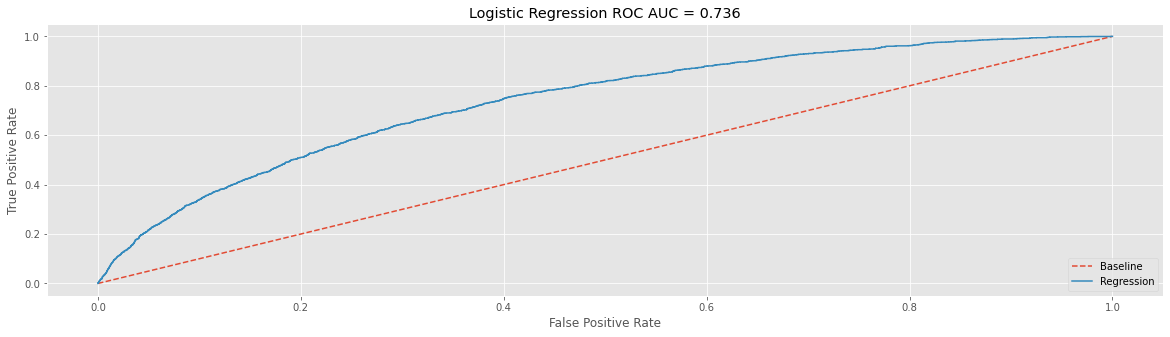

F1: 0.0589


0     1
0  12814  1815
1     72    59

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

get_roc_auc(X_valid, y_valid, model_1)

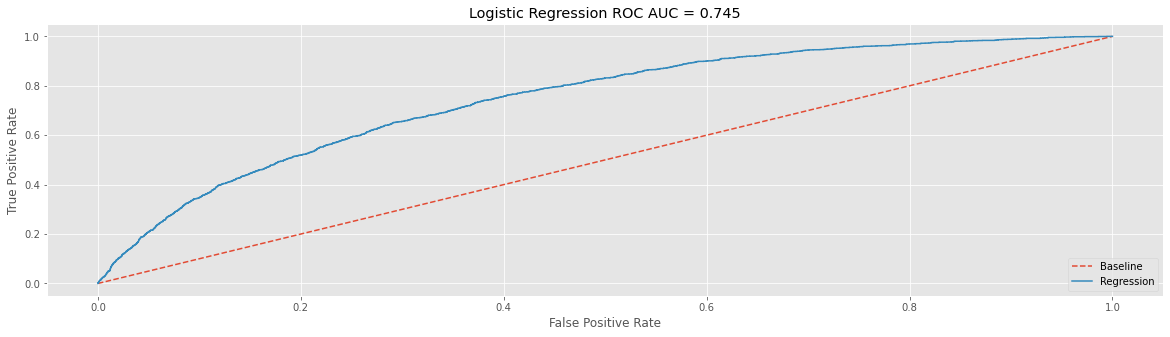

F1: 0.0437


0     1
0  12878  1785
1     55    42

In [97]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

get_roc_auc(X_valid, y_valid, model_1)